<center><h1>QBUS2820 - Predictive Analytics</h1></center>

<center><h1> Assignment 1</h1></center>


In this assignment we will use linear regression approach and techniques such as cross validation into practice. We will also split train set and validation sets, modelling, and evaluate test performance.

**Content:**
<ul>
        <li> <a class="buttom" href="#Import Training and Test sets">Import Training and Test set</a></li>
		<li> <a class="buttom" href="#Exploratory Data Analysis">Exploratory Data Analysis</a></li>
        <li> <a class="buttom" href="#Train Validation Split">Train Validation Split</a></li>
        <li> <a class="buttom" href="#Standarisaton">Standarisaton</a></li>
        <li> <a class="buttom" href="#Modelling">Modelling</a></li>
        <li> <a class="buttom" href="#K-nearest-neighbours">Summary table</a></li>
        <li> <a class="buttom" href="#Model-evaluation">Model evaluation</a></li>
        <li> <a class="buttom" href="#Exercise">Test set performance</a></li>
</ul>

The notebook relies on the following packages. 

In [189]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
# Making sure showing every column and rows in output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 1.0 Import Training and Test sets

In [3]:
data_train = pd.read_csv('ATM_training.csv', index_col=[0])
print(data_train.shape)
data_train.head()

(22000, 6)


,ATMs,Downtown,Weekday,Center,High,Withdraw
Shops,,,,,,
10.18,10,1,0,0,0,72.750556
9.74,10,1,1,0,0,66.720482
0.96,2,0,0,0,1,19.189516
9.58,9,1,1,0,1,67.388669
1.03,4,0,1,0,1,15.813127


In [191]:
data_test = pd.read_csv('ATM_test_without_Withdraw.csv', index_col=[0])
print(data_test.shape)
data_test.head()

(3997, 5)


,ATMs,Downtown,Weekday,Center,High
Shops,,,,,
0.94,4,0,0,0,0
10.05,8,1,1,0,0
10.06,13,1,1,0,0
10.56,12,1,1,0,0
10.17,7,1,1,0,0


## 2.0 Data preprocessing
### 2.1 Reset Index

In [5]:
# Reset Index
data_train = data_train.reset_index()
data_test = data_test.reset_index()

In [6]:
# Set index starts from 1
data_train.index = range(1, len(data_train) + 1)
data_test.index = range(1, len(data_test) + 1)

### 2.2 Check null values and outliers
No NaN or invalid values in the dataset.

All the features have the same count 22000, suggests no missing values values exist in the dataset. 

No obvious outliers in each column.  

In [7]:
data_train.describe()

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
count,22000.000000,22000.000000,22000.00000,22000.000000,22000.000000,22000.000000,22000.000000
mean,7.316373,7.937455,0.70200,0.714091,0.102455,0.301591,54.652818
std,4.118692,3.673415,0.45739,0.451857,0.303252,0.458959,25.099767
min,0.800000,0.000000,0.00000,0.000000,0.000000,0.000000,11.668197
25%,1.050000,4.000000,0.00000,0.000000,0.000000,0.000000,18.500386
50%,9.890000,9.000000,1.00000,1.000000,0.000000,0.000000,68.240749
75%,10.070000,11.000000,1.00000,1.000000,0.000000,1.000000,71.345778
max,10.830000,17.000000,1.00000,1.000000,1.000000,1.000000,103.964065


In [8]:
data_train.head(5)

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
1,10.18,10,1,0,0,0,72.750556
2,9.74,10,1,1,0,0,66.720482
3,0.96,2,0,0,0,1,19.189516
4,9.58,9,1,1,0,1,67.388669
5,1.03,4,0,1,0,1,15.813127


In [9]:
# No missing values in the dataset
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 1 to 22000
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Shops     22000 non-null  float64
 1   ATMs      22000 non-null  int64  
 2   Downtown  22000 non-null  int64  
 3   Weekday   22000 non-null  int64  
 4   Center    22000 non-null  int64  
 5   High      22000 non-null  int64  
 6   Withdraw  22000 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 1.2 MB


In [10]:
data_train.dropna(inplace = True)
data_train.shape

(22000, 7)

In [11]:
data_test.dropna(inplace = True)
data_test.shape

(3997, 6)

In [12]:
data_train.isna().sum()

Shops       0
ATMs        0
Downtown    0
Weekday     0
Center      0
High        0
Withdraw    0
dtype: int64

In [13]:
data_test.isna().sum()

Shops       0
ATMs        0
Downtown    0
Weekday     0
Center      0
High        0
dtype: int64

### 2.3 Check Collinearity issue



**Important Finding from Heatmap:** Correlation between `Shops` and `Downtown` is 1. On Person correlation coeffcient it shows it is 0.999131, suggests collinearity might exist.

These two variables have extremely high correlation with each other, yet they are possible to influence on target variable "Withdraw" on different business perspectives. In absence of sufficient data understanding, retaining these variables avoids mistakenly eliminating variables that have an important impact on business decisions. -> **We'll discuss it on the VIF part.**


1. Withdraw highly correlated with `Shops`, `ATMs`, `Downtown`
2. Withdraw lowly correated with `Weekday`,`Center`,`High`
3. `Weekday, Center, High: lowly correlated with all other features`

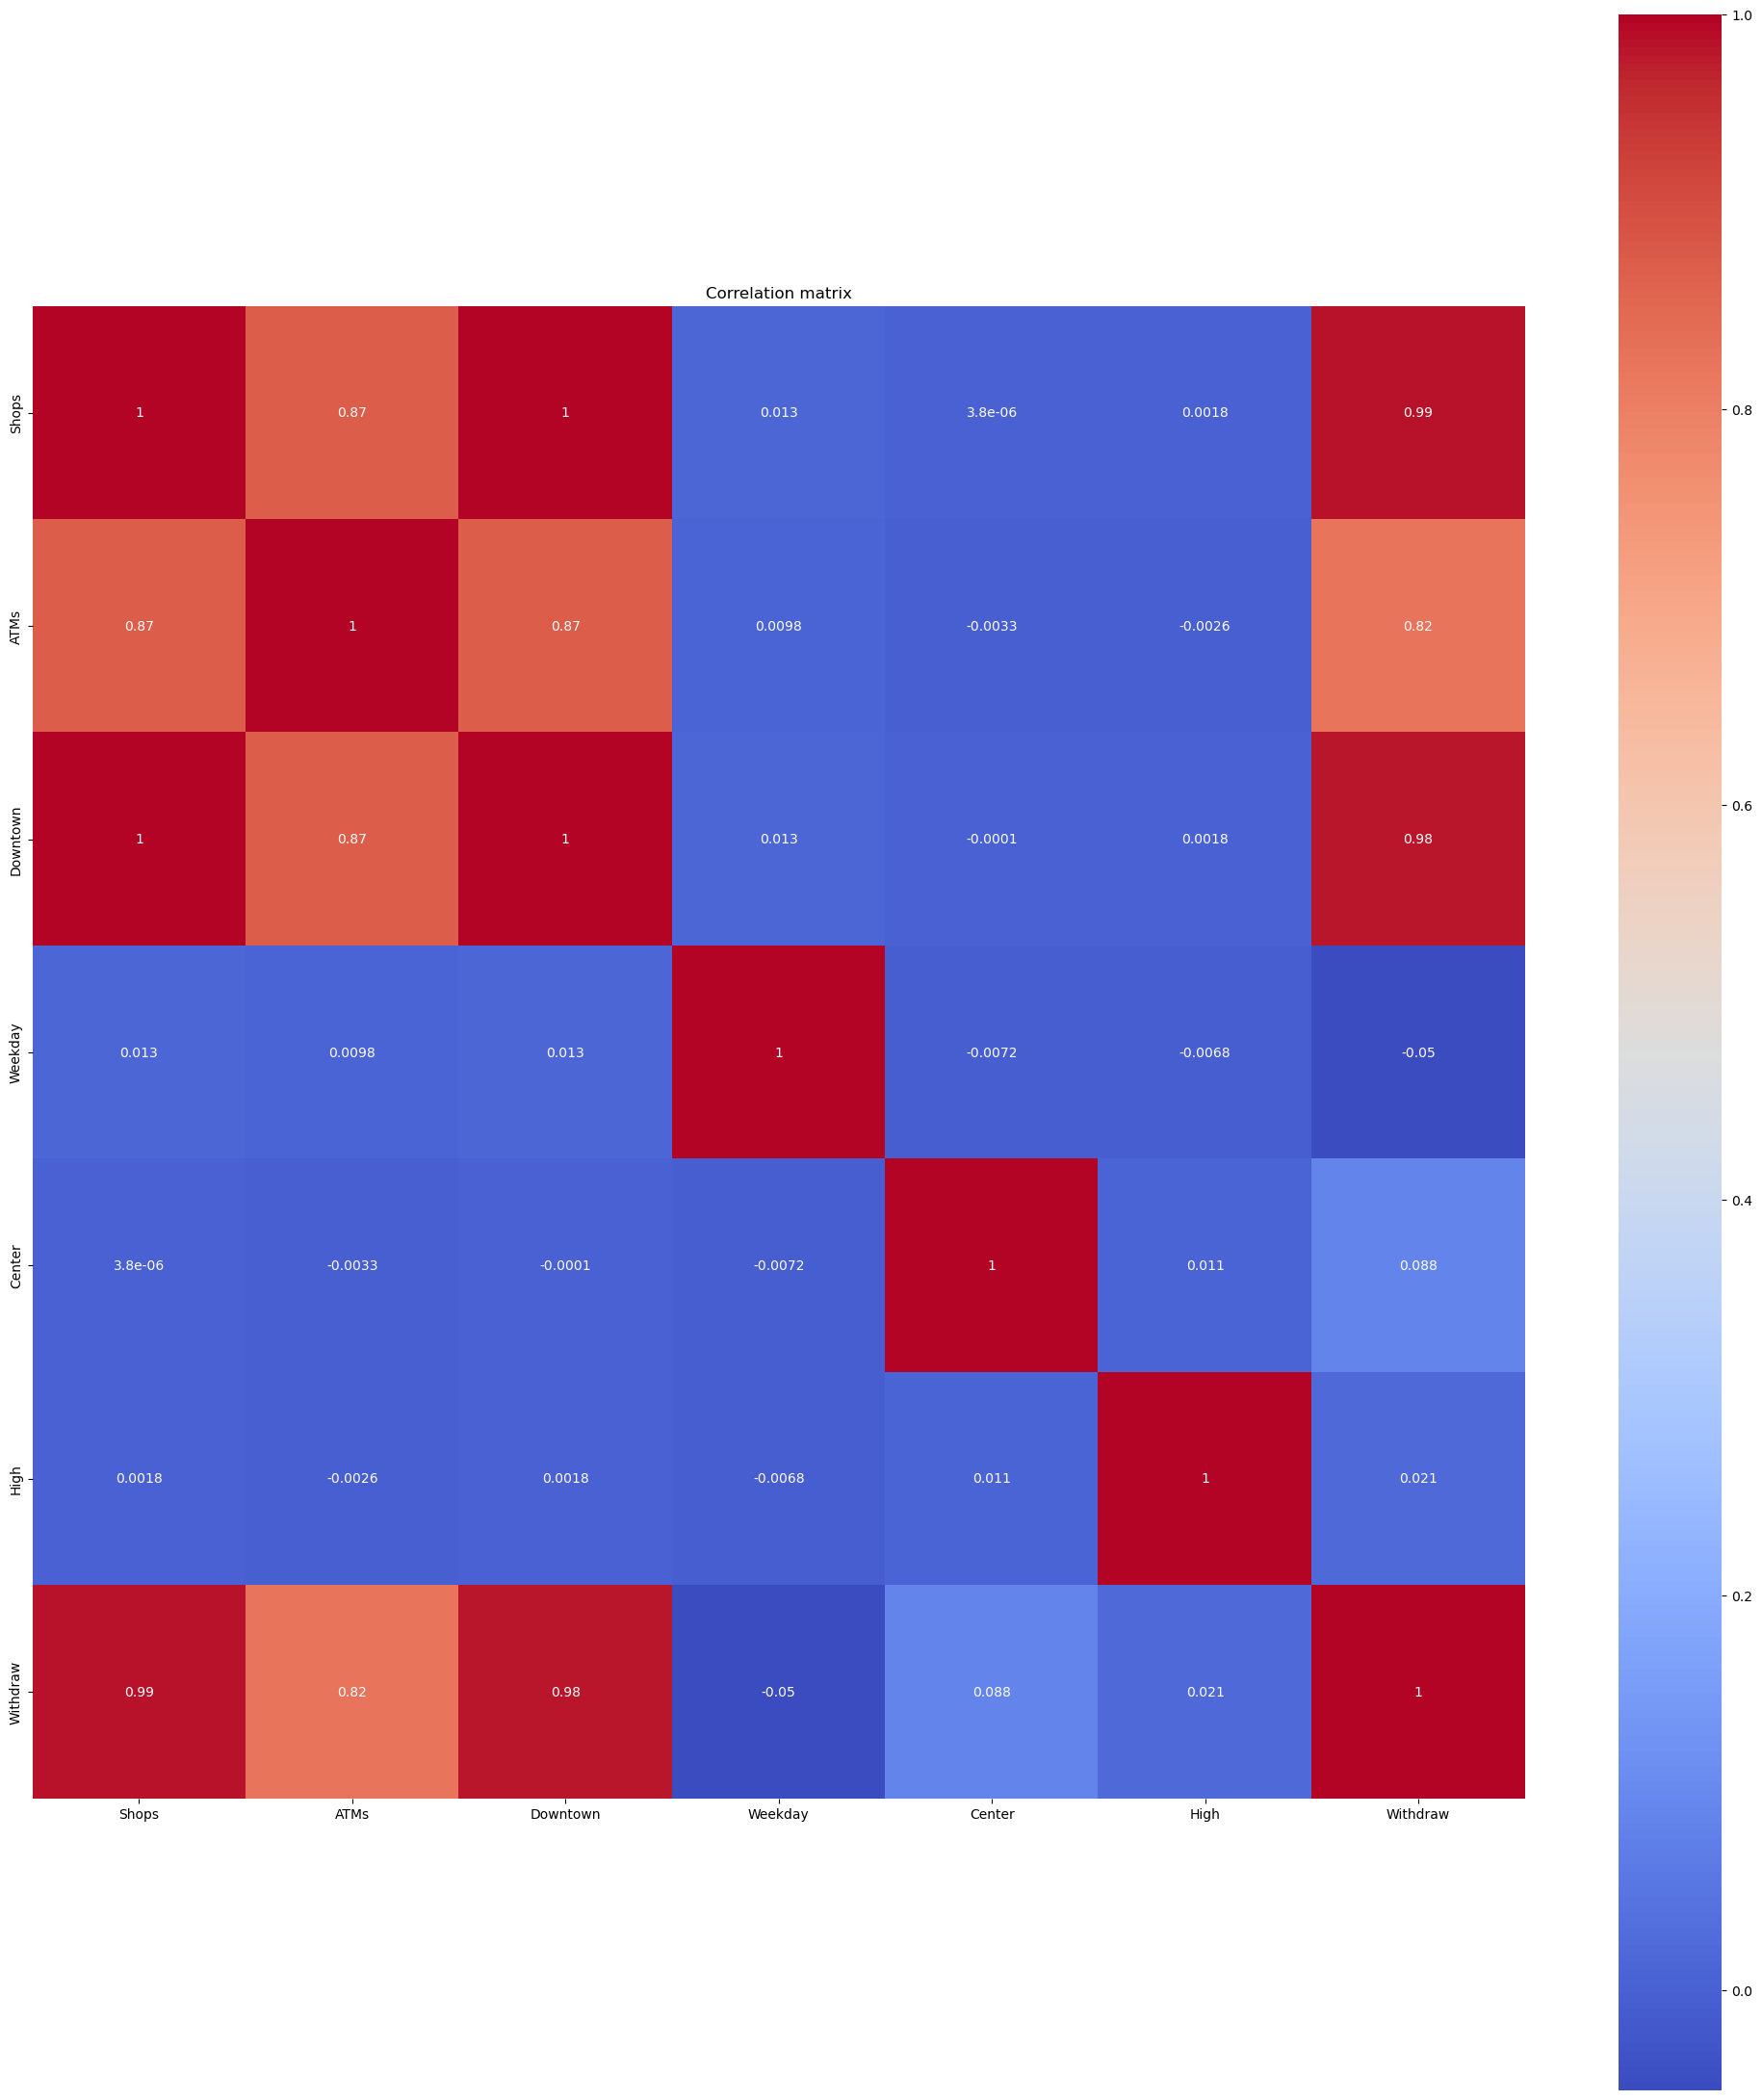

In [14]:
plt.subplots(figsize=(25,28))
sns.heatmap(data_train.corr(),square=True,annot=True,cmap="coolwarm")
plt.title('Correlation matrix')
plt.show()

In [15]:
data_train.corr()

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
Shops,1.000000,0.872903,0.999131,0.013014,0.000004,0.001820,0.985797
ATMs,0.872903,1.000000,0.873726,0.009766,-0.003306,-0.002616,0.824030
Downtown,0.999131,0.873726,1.000000,0.012664,-0.000101,0.001782,0.983574
Weekday,0.013014,0.009766,0.012664,1.000000,-0.007153,-0.006793,-0.050470
Center,0.000004,-0.003306,-0.000101,-0.007153,1.000000,0.010521,0.088103
High,0.001820,-0.002616,0.001782,-0.006793,0.010521,1.000000,0.021275
Withdraw,0.985797,0.824030,0.983574,-0.050470,0.088103,0.021275,1.000000


## 3.0 Exploratory Data Analysis (EDA)

In this section we will discover data features and data patterns.

Each rows records the information of total cash withdrawn per day within an ATM. 

For example, row 1:
- There are approximately 1,018 shops and restaurants within walking distance of the ATM.
- There are other 10 other ATMs around this particular ATM as the `ATMs column`
- This ATM located in downtown as `Downtown = 1`
- The record is not on weekday since `Weekday = 0`
- This ATM is not located in shopping center or at the airport since `Center = 0`
- This ATM does not have a high demand last month since `High = 0`
- Approximately 72750.556 total cash amount in local currency is withdrawn from this ATM as the `Withdraw = 72.750556`

Therefore, the first row represents the record from an `ATM in downtown during a workday`. The `total cash amount be withdrawn from the machine` is approaximately 72750.556 in local currency, where has `1018 shops and 10 ATMs around this particular ATM`.



In [16]:
data_train.head()

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
1,10.18,10,1,0,0,0,72.750556
2,9.74,10,1,1,0,0,66.720482
3,0.96,2,0,0,0,1,19.189516
4,9.58,9,1,1,0,1,67.388669
5,1.03,4,0,1,0,1,15.813127


Pairplot: Visualise the variables

- Numerical variables: No obvious linear relationship. The reason is numerical variables except `Withdraw` are discrete numbers.
- ATMs and Withdraw has multimodel distributions (two main peaks), and categorical variables are dummy, suggests different withdraw patterns might correlate with some cateorical variabels closely. We'll discuss their relationship in the `Modelling` section.

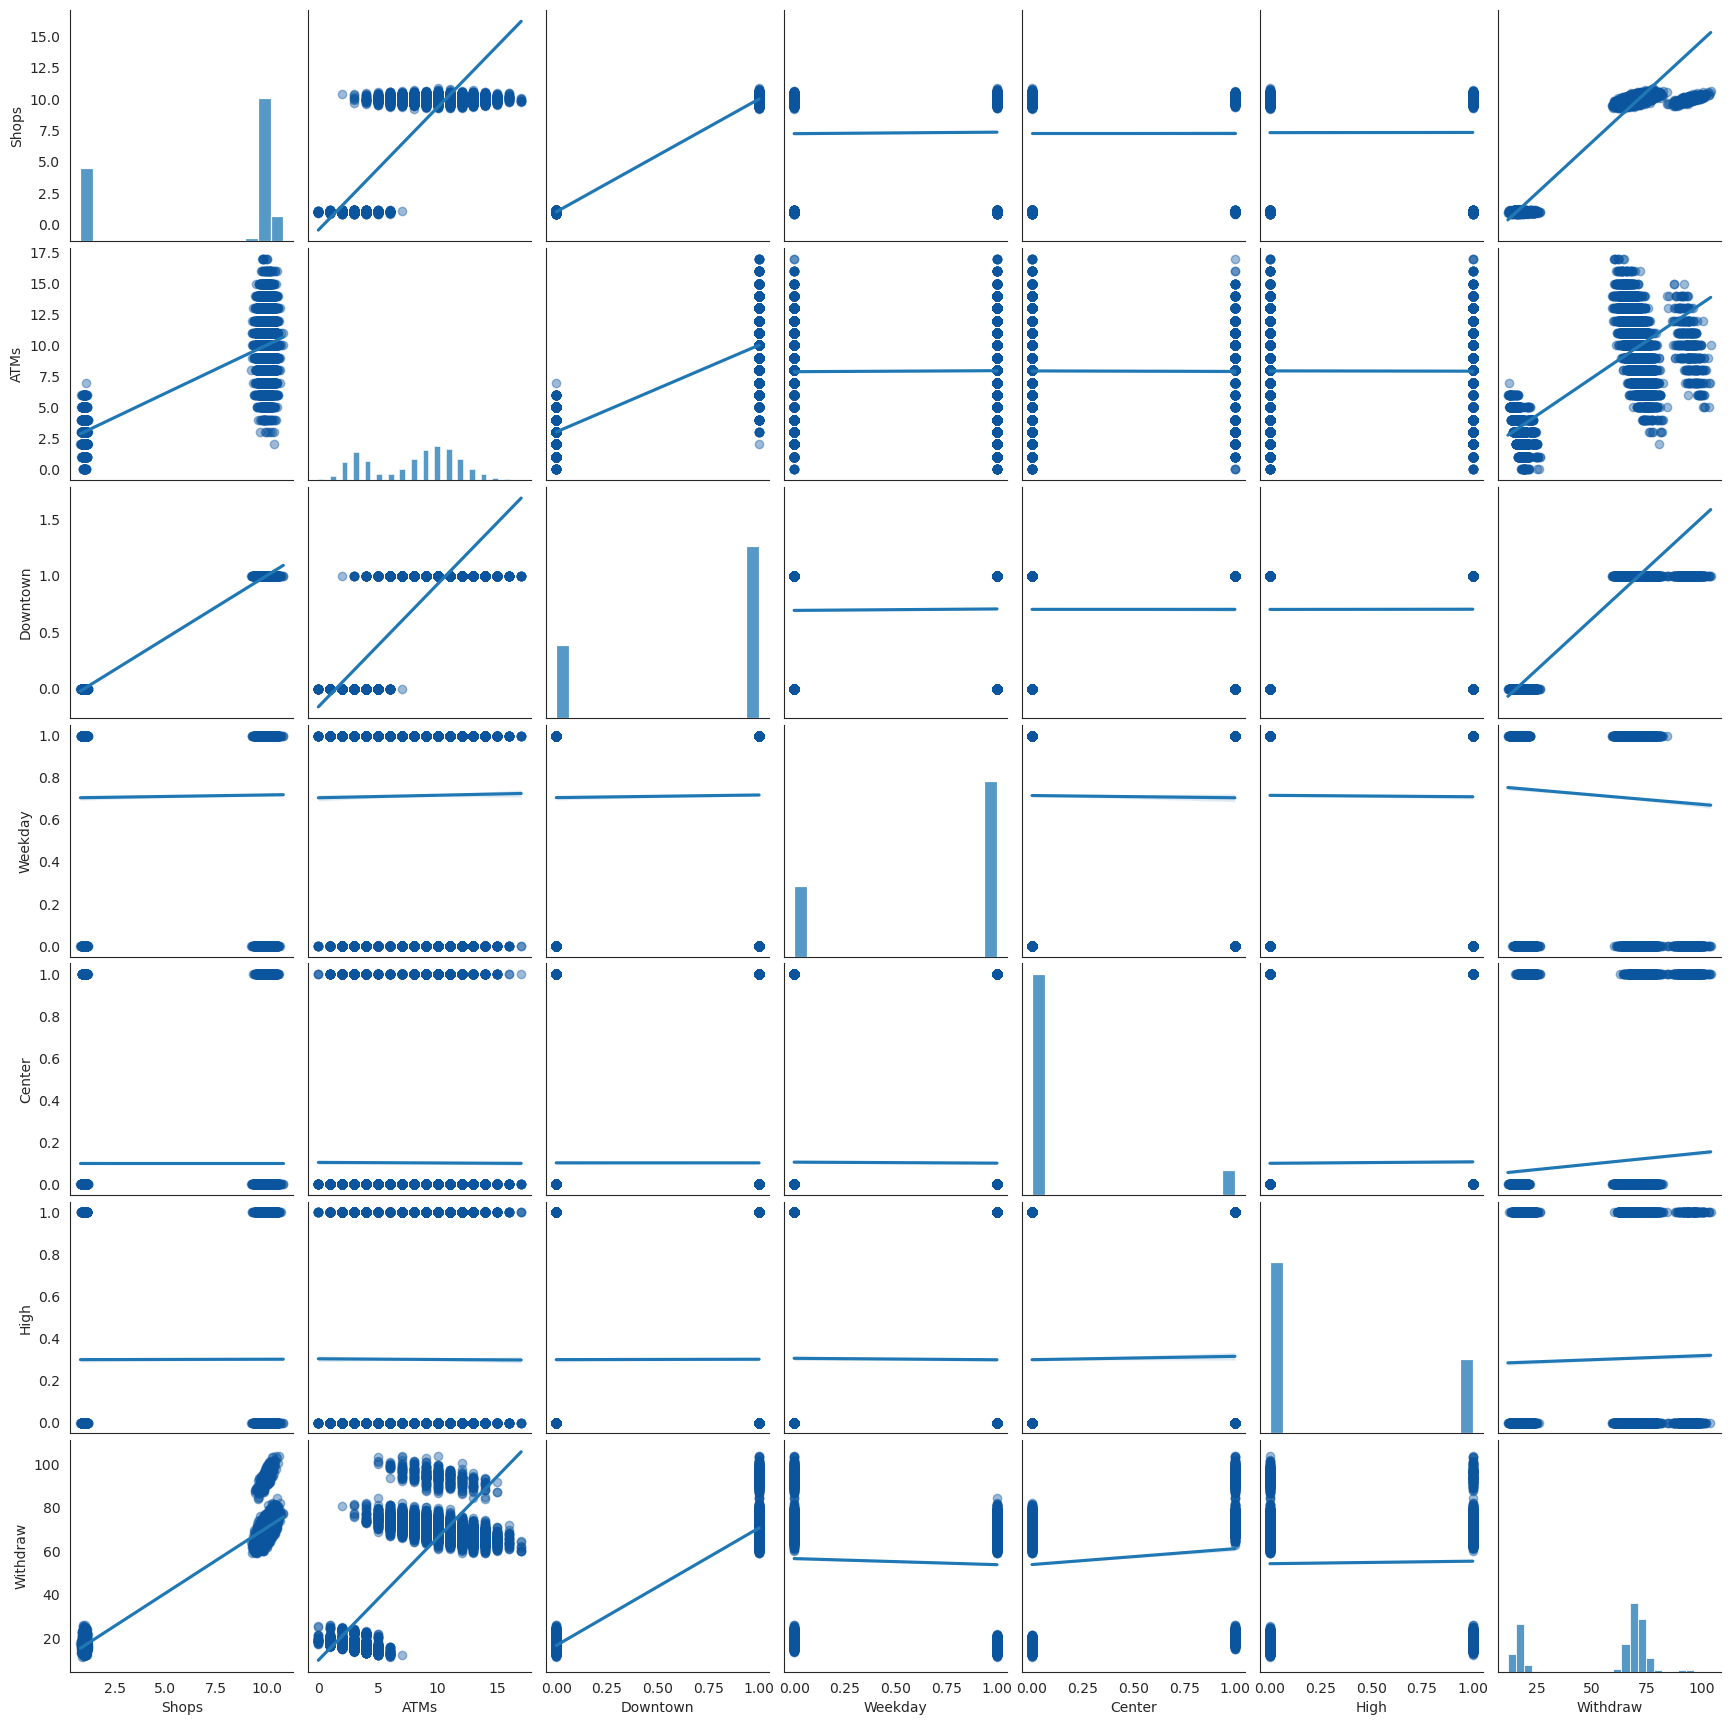

In [17]:
with sns.axes_style('white'):
    g=sns.pairplot(data_train, kind='reg', 
                   plot_kws={'scatter_kws' :{'color': sns.color_palette('Blues')[-1], 'alpha': 0.4}})

**Analysis on Target Variable - Withdraw:**

In [18]:
y = data_train['Withdraw']
y.head()

1    72.750556
2    66.720482
3    19.189516
4    67.388669
5    15.813127
Name: Withdraw, dtype: float64

In [19]:
y.mean()

54.65281758296227

In [20]:
#moderately skewed (value is between -0.5 and -1)
#skew <0, skew to the left, there are more points on the left
y.skew()

-0.772358242576664

In [21]:
#kurt is small, data exhibits a light tail distribution and has less outliers
y.kurt()

-1.170557793157294

Target variable `Withdraw` has a multimodal distribution. The three peaks in the distribution might suggests three different withdraw patterns. Here are some possible explanations:

1. **Small withdrawal group**: The first peak in the distribution might represent the day with small amount cash withdraw, perhaps these days are workdays, or the machine is not located in downtown and center.

2. **Medium withdrawal group**: The second peak might represent another group of days who tend to withdraw moderate amounts of cash, perhaps for consuming in the restaurant or shops.

3. **Large withdrawal group**: While the third peak is not as prominent, its presence suggests there is a smaller group of individuals making large withdrawals. This could be for specific large expenses such as rent payments, travel preparations, or other major purchases.

Moreover, these peaks might correlates with location of ATMs, whether it's weekday etc. 

Multimodal distribution will influence on utilise L1 and L2 loss function (cause multimodal violates the assumption that distribution is Gaussian)

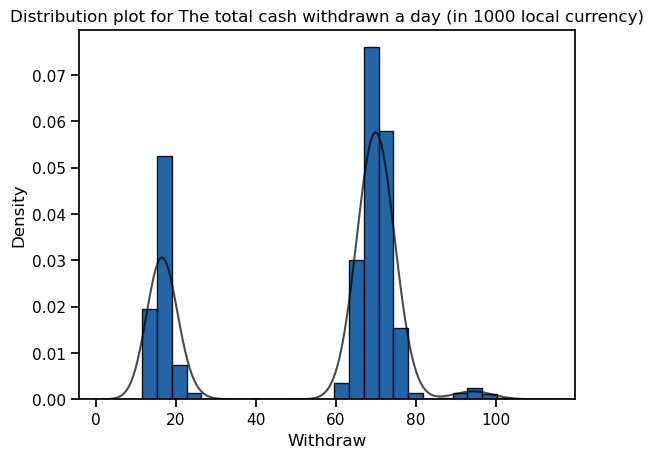

In [22]:
sns.set_context('notebook') # optimises picture for notebook viewing
blue = sns.color_palette('Blues')[-1] # picking a color that I like to use

fig, ax= plt.subplots()
sns.distplot(data_train['Withdraw'], ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black', 'color': blue},
             kde_kws={'color': 'black', 'alpha': 0.7})
ax.set_title('Distribution plot for The total cash withdrawn a day (in 1000 local currency)')
plt.show()

The boxplot tells us:
1. Median is close to the upper quartile, indicates `Withdraw` might be slightly skewed to the left. High amount of cash demand is more concentrated, and lower amount of cash demand are more spread out.
- A higher concentration of values may indicate that users have similar cash needs most of the time. This may reflect consistency or cyclicality in cash transactions, such as an increase in cash withdrawals after payday.
- Low demand diversity: A low dispersion of values indicates that demand for smaller amounts varies widely across users. This may be due to the uncertainty of small daily expenditures, or the different needs of different users for small amounts of cash.
2. No data points exceed the whisker, meaning that all the withdraw amount fell within the normal range of variation and no abnormal withdrawal behavior was recorded.


<AxesSubplot:>

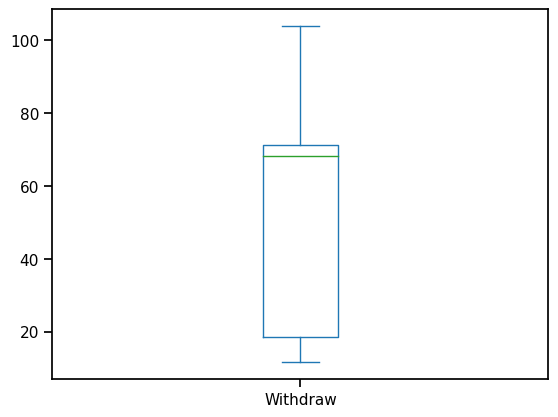

In [23]:
data_train['Withdraw'].plot(kind = 'box')

**K-means: Clustering Target variable**

In order to exploring the withdraw patterns of ATMs on different days, the report used K-means clustering. We find that:
1.	The first cluster: Low withdraw amount days. These data distribute around 20, indicates that on these days, customers total cash withdraw are 20,000 local currencies approximately. 
2.	The second & third cluster: Medium and high cash withdraw days. On some days customers withdraw around 70,000 local currencies, whilst some days customers withdraw around 90,000 local currencies. 

These differences in withdraw behaviour points to potential heterogeneity in the data. In this case, further analysis may be required to identify and understand the causes of these clusters, such as:
- adding interaction or polymial terms in linear regression -> capture complex potential relationships between 'Shops' and 'Withdraw'
- clustering analysis
- cut dataset into different sets, and build models on each sets

In [24]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [25]:
y = data_train[['Withdraw']]

In [26]:
# Find the optimal clusters from 1 to 10
wcss = []
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(y)
    wcss.append(kmeans.inertia_)

As seen from the following plot, WCSS starts to flatten when the number of clusters is more than 2. Thus, we consider 2 as the optimal cluster number.

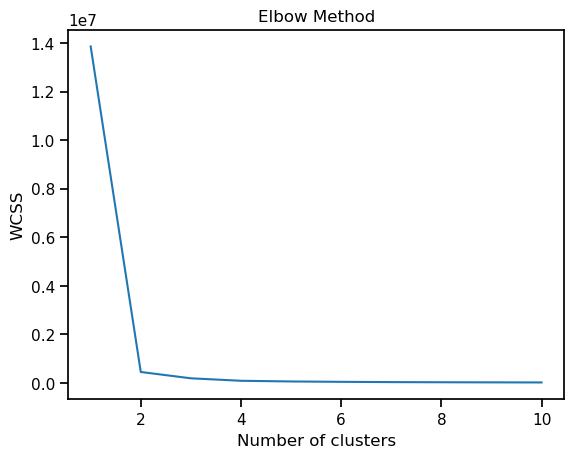

In [27]:
# The plot told us that the optimal number of clusters are 2
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [28]:
# In this case we set 2 as optimal number of clusters
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(y)

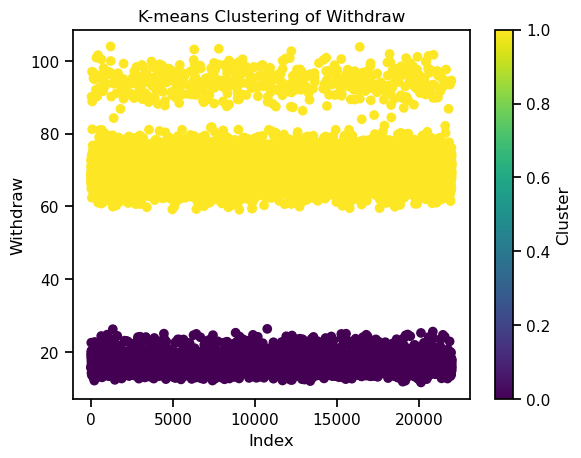

In [29]:
# Put optimal_cluster = 2 in the data_train
data_train['Cluster'] = cluster_labels

plt.scatter(data_train.index, data_train['Withdraw'], c=data_train['Cluster'], cmap='viridis')
plt.title('K-means Clustering of Withdraw')
plt.xlabel('Index')
plt.ylabel('Withdraw')
plt.colorbar(label='Cluster')
plt.show()

In [30]:
data_train = data_train.drop('Cluster', axis=1)

Statistical findings from `Withdraw`:
1. **Great difference between different daily withdraw**: 

- Min total cash withdraw daily is around 11668.197 local currency; 

- Max total cash withdraw daily is around 103,964.065 local currency. 

In [31]:
data_train['Withdraw'].describe()

count    22000.000000
mean        54.652818
std         25.099767
min         11.668197
25%         18.500386
50%         68.240749
75%         71.345778
max        103.964065
Name: Withdraw, dtype: float64

2. `Lowest daily cash withdraw usually happens on weekday, non-downtown and non center area:`

- A notable point:  Low cash withdraw (Withdraw < 13) usually happened on weekday, which is different from intuition. We'll further analysis their relationship on modelling part.

- Most low cash demand usually happened on non-downtown area and non-center area.




In [32]:
withdrawisverysmall = data_train[data_train['Withdraw'] < 12]
withdrawisverysmall

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
19009,0.98,6,0,1,0,0,11.892984
20123,0.90,6,0,1,0,0,11.668197


In [33]:
withdrawissmall = data_train[data_train['Withdraw'] < 13]
print(withdrawissmall.shape)
withdrawissmall.head()

(49, 7)


,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
164,1.09,5,0,1,0,0,12.934786
202,1.14,6,0,1,0,0,12.178277
1454,1.07,7,0,1,0,1,12.382662
1867,0.95,5,0,1,0,0,12.751878
2917,0.92,6,0,1,0,0,12.718610


3. None of the days cash withdraw is 0.

In [34]:
withdrawissmall = data_train[data_train['Withdraw'] == 0]
print(withdrawissmall.shape)
withdrawissmall.head()

(0, 7)


,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw


4. `High cash withdraw usually happens in downtown with many ATM and shops around.`

In [35]:
withdrawisbig = data_train[data_train['Withdraw'] > 72]
print(withdrawisbig.shape)
withdrawisbig.head()

(4503, 7)


,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
1,10.18,10,1,0,0,0,72.750556
25,10.14,8,1,1,0,0,72.390909
28,10.28,11,1,1,1,0,73.829122
30,9.64,9,1,0,1,0,90.142804
42,10.07,9,1,0,0,1,72.898659


In [36]:
withdrawisbig = data_train[data_train['Withdraw'] == 103.964065]
print(withdrawisbig.shape)
withdrawisbig.head()

(1, 7)


,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
1198,10.64,10,1,0,1,1,103.964065


`Analysis on numerical features:`

- The numerical features are: `shops and ATMs`. 
- Shops and ATMs has `nearly perfect positive correlation` with the target variable, reveal that these two features seems to be the key features. 
- Nearly perfect positive correlation might lead to `collinearity problems` (we will discuss this part in the modelling section). 

In [37]:
data_train[['Shops', 'ATMs', 'Withdraw']].corr()

,Shops,ATMs,Withdraw
Shops,1.000000,0.872903,0.985797
ATMs,0.872903,1.000000,0.824030
Withdraw,0.985797,0.824030,1.000000


In [38]:
data_train.corr()

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
Shops,1.000000,0.872903,0.999131,0.013014,0.000004,0.001820,0.985797
ATMs,0.872903,1.000000,0.873726,0.009766,-0.003306,-0.002616,0.824030
Downtown,0.999131,0.873726,1.000000,0.012664,-0.000101,0.001782,0.983574
Weekday,0.013014,0.009766,0.012664,1.000000,-0.007153,-0.006793,-0.050470
Center,0.000004,-0.003306,-0.000101,-0.007153,1.000000,0.010521,0.088103
High,0.001820,-0.002616,0.001782,-0.006793,0.010521,1.000000,0.021275
Withdraw,0.985797,0.824030,0.983574,-0.050470,0.088103,0.021275,1.000000


**ATM:**
- Discrete variable
- Minimum number of ATMs around is 0; Maximum number of ATMs around is 17

In [39]:
data_train['ATMs'].describe()

count    22000.000000
mean         7.937455
std          3.673415
min          0.000000
25%          4.000000
50%          9.000000
75%         11.000000
max         17.000000
Name: ATMs, dtype: float64

In [40]:
data_train['Withdraw'].describe()

count    22000.000000
mean        54.652818
std         25.099767
min         11.668197
25%         18.500386
50%         68.240749
75%         71.345778
max        103.964065
Name: Withdraw, dtype: float64

The following characteristics can be observed from the figure:

- Multi-mode distribution: The graph shows several obvious peaks, especially around 4, 7, 10 and 12, which indicates that there are more ATM machines around some specific number of other ATMs. This distribution may indicate that the location layout of ATMs has a clustering tendency, that is, certain areas tend to have a similar number of ATMs.
- Central tendency of the data: The number of other ATMs around most ATMs is concentrated in the range of 4 to 12, which may reflect a common setting strategy of densely placing ATMs in certain areas to meet high demand.
- Low frequency tail: Data between 0 and above 12 appears less frequently, indicating that few ATMs are completely isolated, and areas with more than 12 other ATMs are also rare.
- This distribution is very useful for understanding the location strategy of ATMs and possible user access patterns. For example, higher ATM density may indicate a commercial area or a high-traffic area, while low density may indicate a residential area or an area with lower demand. 

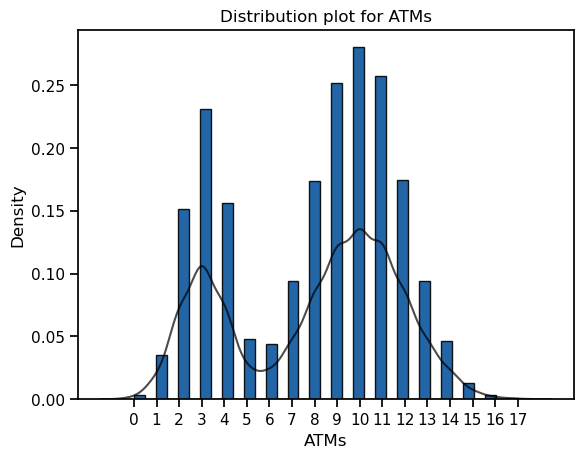

In [41]:
sns.set_context('notebook')
blue = sns.color_palette('Blues')[-1]  

fig, ax = plt.subplots()
sns.distplot(data_train['ATMs'], ax=ax, hist_kws={'alpha': 0.9, 'edgecolor':'black', 'color': blue},
             kde_kws={'color': 'black', 'alpha': 0.7})
ax.set_title('Distribution plot for ATMs')

ax.set_xticks(range(int(min(data_train['ATMs'])), int(max(data_train['ATMs']))+1))

plt.show()

In [42]:
x = data_train['ATMs']

x_with_intercept = sm.add_constant(x, prepend=True)

x_with_intercept.head()

,const,ATMs
1,1.0,10
2,1.0,10
3,1.0,2
4,1.0,9
5,1.0,4


In [43]:
# ATMs relationship with Withdraw
model = sm.OLS(y, x_with_intercept)

results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Withdraw   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                 4.654e+04
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:06   Log-Likelihood:                -89619.
No. Observations:               22000   AIC:                         1.792e+05
Df Residuals:                   21998   BIC:                         1.793e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9614      0.228     43.637      0.0

**Shops:**

In [44]:
data_train['Shops'].describe()

count    22000.000000
mean         7.316373
std          4.118692
min          0.800000
25%          1.050000
50%          9.890000
75%         10.070000
max         10.830000
Name: Shops, dtype: float64

In [45]:
x = data_train['Shops']

x_with_intercept = sm.add_constant(x, prepend=True)

x_with_intercept.head()

,const,Shops
1,1.0,10.18
2,1.0,9.74
3,1.0,0.96
4,1.0,9.58
5,1.0,1.03


In [46]:
# Withdraw Linear Relationship with Shops
model = sm.OLS(y, x_with_intercept)

results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Withdraw   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 7.580e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:07   Log-Likelihood:                -62868.
No. Observations:               22000   AIC:                         1.257e+05
Df Residuals:                   21998   BIC:                         1.258e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6993      0.058    184.677      0.0

In [47]:
x = data_train['ATMs']

x_with_intercept = sm.add_constant(x, prepend=True)

x_with_intercept.head()

,const,ATMs
1,1.0,10
2,1.0,10
3,1.0,2
4,1.0,9
5,1.0,4


In [48]:
# Shops relationship with ATMs
y = data_train['Shops']

model = sm.OLS(y, x_with_intercept)

results = model.fit()

resid = results.resid

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Shops   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                 7.042e+04
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:07   Log-Likelihood:                -46569.
No. Observations:               22000   AIC:                         9.314e+04
Df Residuals:                   21998   BIC:                         9.316e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4521      0.032    -14.016      0.0

In [49]:
data_train['Shops'].describe()

count    22000.000000
mean         7.316373
std          4.118692
min          0.800000
25%          1.050000
50%          9.890000
75%         10.070000
max         10.830000
Name: Shops, dtype: float64

**Analysis on Dummy Variables**:


In [50]:
data_train['Downtown'].value_counts()

1    15444
0     6556
Name: Downtown, dtype: int64

In [51]:
data_train['Weekday'].value_counts()

1    15710
0     6290
Name: Weekday, dtype: int64

In [52]:
data_train['Center'].value_counts()

0    19746
1     2254
Name: Center, dtype: int64

In [53]:
data_train['High'].value_counts()

0    15365
1     6635
Name: High, dtype: int64

Text(0.5, 0, 'History')

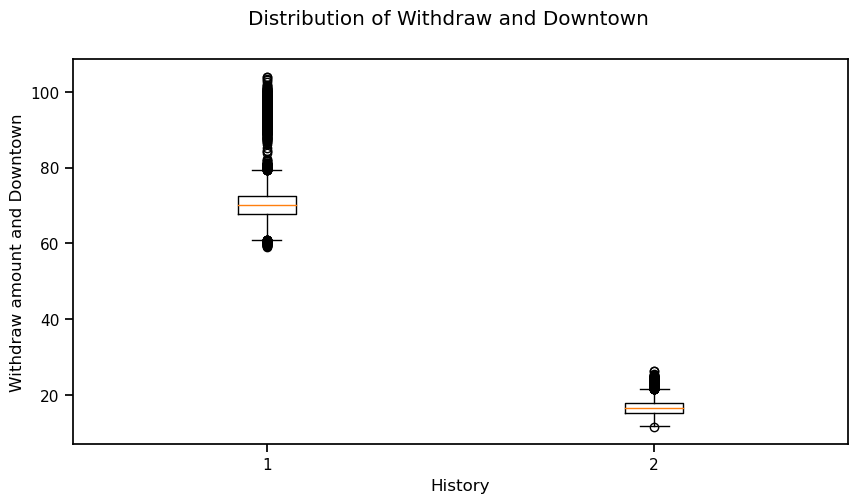

In [54]:
# Make figure wider to fit both boxplots
plt.figure(figsize=(10, 5))
plt.suptitle('Distribution of Withdraw and Downtown')

history_data = [data_train[data_train['Downtown'] == 1]['Withdraw'],
                data_train[data_train['Downtown'] == 0]['Withdraw']]
plt.boxplot(history_data)
plt.ylabel('Withdraw amount and Downtown')
plt.xlabel('History')


## 4.0 Data Processing

Split train and validation after EDA is to make EDA exploring on the whole train dataset.

Standarisation after EDA is to make EDA justify easier.

### 4.1 Train Validation Split 

In [55]:
x = data_train[['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High']]
y = data_train['Withdraw']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [56]:
x_train_subset = x_train[['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High']]
train = pd.concat([x_train_subset, y_train], axis=1)

x_val_subset = x_val[['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High']]
val = pd.concat([x_val_subset, y_val], axis=1)

### 4.2 Standarisation

Makes OLS regression more robust.

Name:

`Train: train set after standarisation`

`Test: test set after standarisation`

`Val: validation set after standarisation.`

In [57]:
response = ['Withdraw']
exclude = response 
predictors_train = [x for x in list(train.columns) if x not in exclude]
train = train[response+predictors_train]

In [58]:
response = ['Withdraw']
exclude = response 
predictors_val = [x for x in list(val.columns) if x not in exclude]
val = val[response+predictors_val]

In [59]:
predictors_test = [x for x in list(data_test.columns) if x not in exclude]
test = data_test[predictors_test]

In [60]:
mu_train=train[predictors_train].mean() # mean for each feature
sigma_train=train[predictors_train].std() # std for each feature

mu_val=val[predictors_val].mean()
sigma_val=val[predictors_val].std() 

mu_test=test[predictors_test].mean()
sigma_test=test[predictors_test].std() 

In [61]:
mu_train.head()

Shops       7.291644
ATMs        7.918466
Downtown    0.699261
Weekday     0.715057
Center      0.100455
dtype: float64

In [62]:
mu_val.head()

Shops       7.415291
ATMs        8.013409
Downtown    0.712955
Weekday     0.710227
Center      0.110455
dtype: float64

In [63]:
mu_test.head()

Shops       7.293338
ATMs        7.860395
Downtown    0.699274
Weekday     0.731799
Center      0.095071
dtype: float64

In [64]:
sigma_train.head()

Shops       4.129262
ATMs        3.683390
Downtown    0.458592
Weekday     0.451400
Center      0.300614
dtype: float64

In [65]:
sigma_val.head()

Shops       4.075105
ATMs        3.632661
Downtown    0.452434
Weekday     0.453708
Center      0.313491
dtype: float64

In [66]:
sigma_test.head()

Shops       4.131500
ATMs        3.630317
Downtown    0.458631
Weekday     0.443078
Center      0.293350
dtype: float64

In [67]:
train[predictors_train]=(train[predictors_train]-mu_train)/sigma_train
val[predictors_val]=(val[predictors_val]-mu_val)/sigma_val
test[predictors_test]=(test[predictors_test]-mu_test)/sigma_test

In [68]:
train.head()

,Withdraw,Shops,ATMs,Downtown,Weekday,Center,High
5208,63.505401,0.605037,1.379581,0.655787,0.631243,-0.334165,-0.658091
4451,16.843804,-1.511564,-1.606799,-1.524800,0.631243,-0.334165,-0.658091
7034,15.024693,-1.516407,-1.335310,-1.524800,0.631243,-0.334165,-0.658091
488,67.957098,0.658315,0.836603,0.655787,0.631243,-0.334165,-0.658091
19538,67.284580,0.624411,0.836603,0.655787,0.631243,-0.334165,-0.658091


In [69]:
data_train.head()

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
1,10.18,10,1,0,0,0,72.750556
2,9.74,10,1,1,0,0,66.720482
3,0.96,2,0,0,0,1,19.189516
4,9.58,9,1,1,0,1,67.388669
5,1.03,4,0,1,0,1,15.813127


We try a linear regression model after standarisation. To see if the model works well.

## 5.0 Modelling

**Content:**
<ul>
        <li> <a class="buttom" href="#1. Stepwise Variable Selection">1. Benchmark Model</a></li>
        <li> <a class="buttom" href="#1. Stepwise Variable Selection">2. Stepwise Variable Selection (Doesn't work well)</a></li>
		<li> <a class="buttom" href="#2. Manually select 5 features">3. Manually select 5 features</a></li>
        <li> <a class="buttom" href="#3. Manually select 4 features">4. Manually select 4 features (With strong collinearity)</a></li>
        <li> <a class="buttom" href="#4. Test VIF of each two variable combinations>5. Test VIF of each two variable combinations: drop 'Shops'</a></li>
        <li> <a class="buttom" href="#5. MLR drop 'Shops': better performs than benchmark model">6. Try Interaction effect: better performs than benchmark model</a></li>
        <li> <a class="buttom" href="#6. Try Log tranformation">7. Try Log tranformation</a></li>
        <li> <a class="buttom" href="#7. Polynomial function">8. Polynomial function</a></li>
</ul>

### 5.1 Benchmark Model:
#### 5.1.1 Modelling Benchmark Model

$$Withdraw = \beta_0 + \beta_1 \times \text{Shops} + \beta_2 \times \text{ATMs} + \beta_3 \times \text{Downtown} + \beta_4 \times \text{Weekday} + \beta_5 \times \text{Center} + \beta_6 \times \text{High} + \epsilon \,$$

<center>where Downtown, weekday, center, and high equals to 1.</center>

- P-value of each features are 0, indeicates all the variables are statistically significant.

- R-squared = 0.99, adjusted R-squared = 0.99:</br>
     1. Indcates the model could explain 99% of the relationship between features and Withdraw. 
     2. However, Adjusting r-squared too high may suggests the model has collinearity problems.

In [70]:
x_with_intercept = sm.add_constant(train[predictors_train], prepend=True)
ols = sm.OLS(train[response],x_with_intercept)
est = ols.fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               Withdraw   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.934e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:07   Log-Likelihood:                -41125.
No. Observations:               17600   AIC:                         8.226e+04
Df Residuals:                   17593   BIC:                         8.232e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.5027      0.019   2887.617      0.0

#### 5.1.2 VIF: check collinearity

In [71]:
# VIF: Check multicollinearity
feature1 = train[['Shops','ATMs','Downtown','Weekday','Center','High']]
feature1 = sm.add_constant(feature1)  
feature1.head()

,const,Shops,ATMs,Downtown,Weekday,Center,High
5208,1.0,0.605037,1.379581,0.655787,0.631243,-0.334165,-0.658091
4451,1.0,-1.511564,-1.606799,-1.524800,0.631243,-0.334165,-0.658091
7034,1.0,-1.516407,-1.335310,-1.524800,0.631243,-0.334165,-0.658091
488,1.0,0.658315,0.836603,0.655787,0.631243,-0.334165,-0.658091
19538,1.0,0.624411,0.836603,0.655787,0.631243,-0.334165,-0.658091


In [72]:
vif = []
for i in range(6):
    vif.append(variance_inflation_factor(feature1.values, i+1))
print(vif)

[581.6085688445406, 4.231955257804198, 584.7407209057305, 1.0004376321922304, 1.000261143709492, 1.0003463132767598]


In [73]:
sum(vif)/6

195.5970483495423

average VIF = 193.775 :

VIF indicator > 5, suggests the model do have collinearity problem.

Highly collinearity may lead to very unstable estimates of model parameters, affecting the reliability and accuracy of model predictions. 

#### 5.1.3 Ridge Cross Validation on Benchmark model

Try to use Ridge CV reduce collinearity problem.

In [74]:
ridge = RidgeCV(cv=10)
ridge.fit(train[predictors_train], np.ravel(train[response])) 

RidgeCV(cv=10)

In [75]:
print("Ridge Lambda: {0}".format(ridge.alpha_))

Ridge Lambda: 0.1


In [76]:
# Print alpha for regularisation
ridge_reg = linear_model.Ridge(alpha=ridge.alpha_)
ridge_reg.fit(train[predictors_train], np.ravel(train[response]))

Ridge(alpha=0.1)

The MSE on the train set of Ridge Regression:

In [77]:
np.mean((ridge_reg.predict(train[predictors_train]) - train[response].to_numpy().T)**2)

6.267594451412464

The MSE on the validation set of Ridge Regression:

In [78]:
np.mean((ridge_reg.predict(val[predictors_val]) - val[response].to_numpy().T)**2)

6.875278718465255

The MSE on the train set of OLS Regression:

In [79]:
np.mean((est.predict(sm.add_constant(train[predictors_train], prepend=True)).to_numpy() - train[response].to_numpy().T)**2)

6.267525408187273

The MSE on the validation set of OLS Regression:

In [80]:
np.mean((est.predict(sm.add_constant(val[predictors_val], prepend=True)).to_numpy() - val[response].to_numpy().T)**2)

6.875204659001453

**Conclusion:** Two model performance are similar on train set and validation set. Yet Ridge will provide us a more robust estimate coefficient under multicollinearity, and give us better performance on the test set.

#### 5.1.4 Summary table of Benchmark model and Ridge CV Benchmark Model

| Model | Train MSE | Validation MSE | 
| --- | --- | --- |
| Benchmark Model (OLS Reg) | 6.1869 | 6.6361|
| Benchmark Ridge Regression | 6.1870| 6.6355 |

(After 4 decimal points validation set MSE two models perform different.)

**Conclusion:** 

The model perfromance gives similar results on the validation set and train set.

### 5.2 Variable selection

VIF of benchmark is very high, and we know from EDA that `Shops` and `Downtown` have very high correlation with `Withdraw` and each other. In order to reduce the influence of collinearity issues, we do variable selection.



#### 5.2.1 Stepwise Variable Selection:
1. Try to drop 'High' (5 features left):

 $$Withdraw = \beta_0 + \beta_1 \times \text{Shops} + \beta_2 \times \text{ATMs} + \beta_3 \times \text{Downtown} + \beta_4 \times \text{Weekday} + \beta_5 \times \text{Center} + \epsilon \,$$

<center>where Downtown, weekday, center, and high equals to 1.</center>

In [81]:
sfs1 = SFS(ridge, 
           k_features=5, 
           forward=True, 
           floating=False, 
           verbose=3,
           scoring='neg_mean_squared_error',
           cv=5)

sfs1 = sfs1.fit(train[predictors_train], train[response].values.ravel()) 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    2.4s finished

[2024-05-05 23:53:10] Features: 1/5 -- score: -17.878203291800425[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.6s finished

[2024-05-05 23:53:13] Features: 2/5 -- score: -12.92216372176215[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Paral

We have the Selected features in the attribute `k_feature_idx_` of `sfs`

In [82]:
print('Selected features:', sfs1.k_feature_idx_)

Selected features: (0, 1, 2, 3, 4)


In [83]:
# get the list of selected predictors
selected_predictors = [predictors_train[index] for index in sfs1.k_feature_idx_]
selected_predictors

['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center']

In [84]:
predictions_stepwise = LinearRegression().fit(train[selected_predictors], train[response])

In [85]:
x_with_intercept = sm.add_constant(train[selected_predictors], prepend=True)
ols = sm.OLS(train[response],x_with_intercept)
est = ols.fit()
print(est.summary())


                            OLS Regression Results                            
Dep. Variable:               Withdraw   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.410e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:18   Log-Likelihood:                -41403.
No. Observations:               17600   AIC:                         8.282e+04
Df Residuals:                   17594   BIC:                         8.286e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         54.5027      0.019   2842.391      0.0

**VIF:**

In [86]:
feature1 = train[['Shops','ATMs','Downtown','Weekday','Center']]
feature1 = sm.add_constant(feature1)  

for i in range(5):
    vif.append(variance_inflation_factor(feature1.values, i+1))
print(vif)

[581.6085688445406, 4.231955257804198, 584.7407209057305, 1.0004376321922304, 1.000261143709492, 1.0003463132767598, 581.6085106901609, 4.231401462764726, 584.7398297344567, 1.0003445689544948, 1.0001438797004027]


In [87]:
sum(vif)/5

469.2325040866582

The MSE on train set of OLS:

In [88]:
# MSE increases than benchmark
np.mean((est.predict(sm.add_constant(train[selected_predictors], prepend=True)).to_numpy() - train[response].to_numpy().T)**2)

6.468929220549149

The MSE on validation set of OLS:

In [89]:
np.mean((est.predict(sm.add_constant(val[selected_predictors], prepend=True)).to_numpy() - val[response].to_numpy().T)**2)

7.0317614882321555

**Findings:** When the variable "High" is removed, the correlation between the remaining variables increases, resulting in higher collinearity. AIC and BIC also increase, and the adjusted R square remains unchanged. This may be because there is some balancing effect between the removed variable and other variables, and when it is removed, the relationship between other variables becomes more obvious.

**Decision:** We will keep 'High' shortly.

#### 5.2.2 Manually select 5 features

In [90]:
# 5 features left, drop Shop
x_with_intercept = smf.ols(formula= 'Withdraw ~ ATMs + Downtown + Weekday + Center + High', data = train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.267e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:18   Log-Likelihood:                -44951.
No. Observations:               17600   AIC:                         8.991e+04
Df Residuals:                   17594   BIC:                         8.996e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5027      0.023   2323.453      0.000      54.457      54.549
ATMs          -3.7239      0.048    -77.167      0.000      -3.818      -3.629
Downtown      28.0345      0.048    580.921      0.000      27.940      28.129
Weekday       -1.5689      0.023    -66.866      0.000      -1.615      -1.523
Center         2.1953      0.023     93.572      0.000       2.149       2.241
High           0.4483      0.023     19.107      0.000       0.402       0.494
==============================================================================
Omnibus:                     8072.849   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79375.755
Skew:                           1.959   Prob(JB):                         0.00
Kurtosis:                      12.638   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
feature1 = train[['High','ATMs','Downtown','Weekday','Center']]
feature1 = sm.add_constant(feature1)  

for i in range(5):
    vif.append(variance_inflation_factor(feature1.values, i+1))
print(vif)

[581.6085688445406, 4.231955257804198, 584.7407209057305, 1.0004376321922304, 1.000261143709492, 1.0003463132767598, 581.6085106901609, 4.231401462764726, 584.7398297344567, 1.0003445689544948, 1.0001438797004027, 1.0003462132532353, 4.231950161110255, 4.232134270003637, 1.0003754541095193, 1.0002605831393399]


In [92]:
sum(vif)/5

471.5255174229813

In [93]:
# 5 features left, drop ATMs
x_with_intercept = smf.ols(formula= 'Withdraw ~ Shops + Downtown + Weekday + Center + High', data = train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.298e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:19   Log-Likelihood:                -44832.
No. Observations:               17600   AIC:                         8.968e+04
Df Residuals:                   17594   BIC:                         8.972e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5027      0.023   2339.183      0.000      54.457      54.548
Shops         44.5118      0.562     79.213      0.000      43.410      45.613
Downtown     -19.6932      0.562    -35.046      0.000     -20.795     -18.592
Weekday       -1.5766      0.023    -67.648      0.000      -1.622      -1.531
Center         2.2057      0.023     94.651      0.000       2.160       2.251
High           0.4696      0.023     20.152      0.000       0.424       0.515
==============================================================================
Omnibus:                     8156.522   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78329.745
Skew:                           1.994   Prob(JB):                         0.00
Kurtosis:                      12.535   Cond. No.                         48.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
feature1 = train[['High','Shops','Downtown','Weekday','Center']]
feature1 = sm.add_constant(feature1)  

for i in range(5):
    vif.append(variance_inflation_factor(feature1.values, i+1))
print(vif)

[581.6085688445406, 4.231955257804198, 584.7407209057305, 1.0004376321922304, 1.000261143709492, 1.0003463132767598, 581.6085106901609, 4.231401462764726, 584.7398297344567, 1.0003445689544948, 1.0001438797004027, 1.0003462132532353, 4.231950161110255, 4.232134270003637, 1.0003754541095193, 1.0002605831393399, 1.0002154076333172, 581.6078683927257, 581.6031278007014, 1.000423334367173, 1.00023668511266]


In [95]:
sum(vif)/5

704.7678917470893

In [96]:
# 5 features left, drop Downtown
x_with_intercept = smf.ols(formula= 'Withdraw ~ Shops + ATMs + Weekday + Center + High', data = train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 3.275e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:19   Log-Likelihood:                -41754.
No. Observations:               17600   AIC:                         8.352e+04
Df Residuals:                   17594   BIC:                         8.357e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5027      0.020   2786.272      0.000      54.464      54.541
Shops         28.1805      0.040    702.148      0.000      28.102      28.259
ATMs          -3.8308      0.040    -95.451      0.000      -3.909      -3.752
Weekday       -1.5786      0.020    -80.684      0.000      -1.617      -1.540
Center         2.1960      0.020    112.247      0.000       2.158       2.234
High           0.4480      0.020     22.899      0.000       0.410       0.486
==============================================================================
Omnibus:                    12869.043   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           277747.187
Skew:                           3.326   Prob(JB):                         0.00
Kurtosis:                      21.289   Cond. No.                         3.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
feature1 = train[['Shops','ATMs','High','Weekday','Center']]
feature1 = sm.add_constant(feature1)  

for i in range(5):
    vif.append(variance_inflation_factor(feature1.values, i+1))
print(vif)

[581.6085688445406, 4.231955257804198, 584.7407209057305, 1.0004376321922304, 1.000261143709492, 1.0003463132767598, 581.6085106901609, 4.231401462764726, 584.7398297344567, 1.0003445689544948, 1.0001438797004027, 1.0003462132532353, 4.231950161110255, 4.232134270003637, 1.0003754541095193, 1.0002605831393399, 1.0002154076333172, 581.6078683927257, 581.6031278007014, 1.000423334367173, 1.00023668511266, 4.209464926817923, 4.209247494922375, 1.0003447887038088, 1.0003878346437842, 1.000260121253044]


In [98]:
sum(vif)/5

707.0518327803575

In [99]:
# 5 features left, drop Weekday
x_with_intercept = smf.ols(formula= 'Withdraw ~ Shops + ATMs + Downtown + Center + High', data = train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 2.505e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:19   Log-Likelihood:                -44085.
No. Observations:               17600   AIC:                         8.818e+04
Df Residuals:                   17594   BIC:                         8.823e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5027      0.022   2440.689      0.000      54.459      54.546
Shops         44.2588      0.539     82.183      0.000      43.203      45.314
ATMs          -3.7158      0.046    -80.884      0.000      -3.806      -3.626
Downtown     -16.2130      0.540    -30.025      0.000     -17.271     -15.155
Center         2.2132      0.022     99.101      0.000       2.169       2.257
High           0.4641      0.022     20.782      0.000       0.420       0.508
==============================================================================
Omnibus:                    13587.286   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           325704.798
Skew:                           3.569   Prob(JB):                         0.00
Kurtosis:                      22.829   Cond. No.                         57.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
feature1 = train[['Shops','ATMs','High','Downtown','Center']]
feature1 = sm.add_constant(feature1)  

for i in range(5):
    vif.append(variance_inflation_factor(feature1.values, i+1))
print(vif)

[581.6085688445406, 4.231955257804198, 584.7407209057305, 1.0004376321922304, 1.000261143709492, 1.0003463132767598, 581.6085106901609, 4.231401462764726, 584.7398297344567, 1.0003445689544948, 1.0001438797004027, 1.0003462132532353, 4.231950161110255, 4.232134270003637, 1.0003754541095193, 1.0002605831393399, 1.0002154076333172, 581.6078683927257, 581.6031278007014, 1.000423334367173, 1.00023668511266, 4.209464926817923, 4.209247494922375, 1.0003447887038088, 1.0003878346437842, 1.000260121253044, 581.5724213581708, 4.231894776516827, 1.0002532585337407, 584.7116149890043, 1.0001522143320691]


In [101]:
sum(vif)/5

941.5551000996691

In [102]:
# 5 features left, drop Center
x_with_intercept = smf.ols(formula= 'Withdraw ~ Shops + ATMs + Downtown + Weekday + High', data = train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 1.974e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:19   Log-Likelihood:                -46148.
No. Observations:               17600   AIC:                         9.231e+04
Df Residuals:                   17594   BIC:                         9.235e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5027      0.025   2170.720      0.000      54.453      54.552
Shops         44.5201      0.606     73.522      0.000      43.333      45.707
ATMs          -3.7504      0.052    -72.608      0.000      -3.852      -3.649
Downtown     -16.4294      0.607    -27.059      0.000     -17.620     -15.239
Weekday       -1.6064      0.025    -63.965      0.000      -1.656      -1.557
High           0.4727      0.025     18.822      0.000       0.423       0.522
==============================================================================
Omnibus:                    17738.358   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           737006.354
Skew:                           5.203   Prob(JB):                         0.00
Kurtosis:                      32.945   Cond. No.                         57.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [103]:
feature1 = train[['Shops','ATMs','High','Weekday','Downtown']]
feature1 = sm.add_constant(feature1)  

for i in range(5):
    vif.append(variance_inflation_factor(feature1.values, i+1))
print(vif)

[581.6085688445406, 4.231955257804198, 584.7407209057305, 1.0004376321922304, 1.000261143709492, 1.0003463132767598, 581.6085106901609, 4.231401462764726, 584.7398297344567, 1.0003445689544948, 1.0001438797004027, 1.0003462132532353, 4.231950161110255, 4.232134270003637, 1.0003754541095193, 1.0002605831393399, 1.0002154076333172, 581.6078683927257, 581.6031278007014, 1.000423334367173, 1.00023668511266, 4.209464926817923, 4.209247494922375, 1.0003447887038088, 1.0003878346437842, 1.000260121253044, 581.5724213581708, 4.231894776516827, 1.0002532585337407, 584.7116149890043, 1.0001522143320691, 581.6082428972899, 4.231851777140059, 1.0002290392829534, 1.000328683595046, 584.7401231898868]


In [104]:
sum(vif)/5

1176.071255217108

**Summary Table: MLR with 5 features (no transform and interaction)**
| MLR Model | Adjusted R-squard | AIC | VIF|
| --- | --- | --- | --- |    
|Benchmark Model | 0.990 |1.028e+05| 193.7749  |
| Drop High | 0.990 | 1.034e+05 |464.8596|
| Drop Shop | 0.985 |  1.124e+05|467.1506|
| Drop ATMs | 0.985 | 1.120e+05 |698.1343|
| Drop Downtown | 0.989 | 1.044e+05 |700.4151|
| Drop Weekday | 0.986 | 1.102e+05 | 932.7290|
| Drop Center | 0.983 | 1.152e+05 |2565.47031|

**Findings:** drop 1 feature does not significantly influence on adjusted R-squared and AIC. However, VIF increases significantly. Collinearity is worse.

**Conclusion:** Benchmark model performance better than MLR with 5 features directly. Drop 1 variable has negative impact on model performance.

#### 5.2.3 Manually select 4 features

In [105]:
# 4 features left, drop ATMs, Downtown
# R-squared nearly the same, but AIC & BIC higher
x_with_intercept = smf.ols(formula= 'Withdraw ~ Shops + Weekday + Center + High', data = train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 2.683e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:19   Log-Likelihood:                -45426.
No. Observations:               17600   AIC:                         9.086e+04
Df Residuals:                   17595   BIC:                         9.090e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5027      0.024   2261.640      0.000      54.455      54.550
Shops         24.8355      0.024   1030.455      0.000      24.788      24.883
Weekday       -1.5706      0.024    -65.159      0.000      -1.618      -1.523
Center         2.2051      0.024     91.491      0.000       2.158       2.252
High           0.4693      0.024     19.471      0.000       0.422       0.517
==============================================================================
Omnibus:                     7451.748   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64430.335
Skew:                           1.815   Prob(JB):                         0.00
Kurtosis:                      11.642   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
feature1 = train[['Shops','Weekday','Center','High']]
feature1 = sm.add_constant(feature1)  

for i in range(4):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/4

1471.0893179731713

In [107]:
# 4 features left, drop Shop, Downtown
# much less fit, AIC & BIC higher
x_with_intercept = smf.ols(formula= 'Withdraw ~ ATMs + Weekday + Center + High', data = train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     9861.
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:19   Log-Likelihood:                -71393.
No. Observations:               17600   AIC:                         1.428e+05
Df Residuals:                   17595   BIC:                         1.428e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5027      0.105    517.220      0.000      54.296      54.709
ATMs          20.7745      0.105    197.128      0.000      20.568      20.981
Weekday       -1.4407      0.105    -13.670      0.000      -1.647      -1.234
Center         2.2378      0.105     21.233      0.000       2.031       2.444
High           0.5956      0.105      5.651      0.000       0.389       0.802
==============================================================================
Omnibus:                      467.755   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              504.011
Skew:                           0.412   Prob(JB):                    3.59e-110
Kurtosis:                       2.905   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [108]:
feature1 = train[['ATMs','Weekday','Center','High']]
feature1 = sm.add_constant(feature1)  

for i in range(4):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/4

1472.0895406327124

In [109]:
# 4 features left, drop Shop, ATMs
# much less fit, AIC & BIC higher
x_with_intercept = smf.ols(formula= 'Withdraw ~ Downtown + Weekday + Center + High', data = train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 2.106e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:19   Log-Likelihood:                -47516.
No. Observations:               17600   AIC:                         9.504e+04
Df Residuals:                   17595   BIC:                         9.508e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5027      0.027   2008.376      0.000      54.449      54.556
Downtown      24.7802      0.027    913.027      0.000      24.727      24.833
Weekday       -1.5620      0.027    -57.548      0.000      -1.615      -1.509
Center         2.2043      0.027     81.214      0.000       2.151       2.257
High           0.4690      0.027     17.280      0.000       0.416       0.522
==============================================================================
Omnibus:                     5224.644   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30753.097
Skew:                           1.298   Prob(JB):                         0.00
Kurtosis:                       8.933   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
feature1 = train[['Downtown','Weekday','Center','High']]
feature1 = sm.add_constant(feature1)  

for i in range(4):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/4

1473.0897855128117

**Summary Table: MLR with 4 features (no transform and interaction)**
| MLR Model | Adjusted R-squard | AIC | VIF|
| --- | --- | --- | --- |    
|Benchmark Model | 0.990 |1.028e+05| 193.7749  |
| Drop ATMs, Downtown | 0.984 |  1.135e+05|1457.3221|
| Drop Shops, Downtown | 0.691 | 1.784e+05 |1458.3223|
| Drop Shops, ATMs | 0.979 | 1.188e+05 |1459.3225|

**Findings:** 
1. Drop Shops and downtown together has a significantly effect on R-squared decreases. However, VIF is still very high.
2. Higher VIF suggests stronger collinearity  problem. We don't measure MSE here cause from VIF we know overfitting is still very strong in models. 

**Conclusions:** Drop two variables make VIF bigger. Benchmark Model still performs the best comparing with the other variables.


#### 5.2.4 Test VIF between each two features

In [111]:
x_with_intercept = smf.ols(formula= 'Withdraw ~ Weekday + Center + High', data = train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     60.90
Date:                Sun, 05 May 2024   Prob (F-statistic):           3.65e-39
Time:                        23:53:19   Log-Likelihood:                -81652.
No. Observations:               17600   AIC:                         1.633e+05
Df Residuals:                   17596   BIC:                         1.633e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5027      0.189    288.757      0.000      54.133      54.873
Weekday       -1.2508      0.189     -6.626      0.000      -1.621      -0.881
Center         2.1428      0.189     11.351      0.000       1.773       2.513
High           0.5103      0.189      2.703      0.007       0.140       0.880
==============================================================================
Omnibus:                    23324.379   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3018.006
Skew:                          -0.805   Prob(JB):                         0.00
Kurtosis:                       1.766   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
feature1 = train[['Weekday','Center','High']]
feature1 = sm.add_constant(feature1)  

for i in range(3):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/3

1965.1199293222055

In [113]:
x_with_intercept = smf.ols(formula= 'Withdraw ~ Shops + Weekday + High', data = train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 2.405e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:20   Log-Likelihood:                -48851.
No. Observations:               17600   AIC:                         9.771e+04
Df Residuals:                   17596   BIC:                         9.774e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5027      0.029   1861.791      0.000      54.445      54.560
Shops         24.8300      0.029    848.088      0.000      24.773      24.887
Weekday       -1.5936      0.029    -54.427      0.000      -1.651      -1.536
High           0.4933      0.029     16.849      0.000       0.436       0.551
==============================================================================
Omnibus:                    12803.853   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           248506.214
Skew:                           3.347   Prob(JB):                         0.00
Kurtosis:                      20.149   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
feature1 = train[['Weekday','High']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

2948.6799880792973

In [115]:
feature1 = train[['Shops','High']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

2949.679990330001

In [116]:
feature1 = train[['Weekday','Shops']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

2950.6801564266557

In [117]:
feature1 = train[['Downtown','Shops']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

3532.2514086662345

In [118]:
feature1 = train[['Center','Shops']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

3533.251415566708

In [119]:
feature1 = train[['ATMs','Shops']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

3537.4599400627717

In [120]:
feature1 = train[['Downtown','Shops']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

4119.031192302351

In [121]:
feature1 = train[['Downtown','ATMs']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

4123.262424754039

In [122]:
feature1 = train[['Weekday','ATMs']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

4124.262509968305

In [123]:
feature1 = train[['Center','ATMs']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

4125.262532183888

In [124]:
feature1 = train[['High','ATMs']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

4126.262550189951

In [125]:
feature1 = train[['Downtown','Weekday']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

4127.262708229526

In [126]:
feature1 = train[['Downtown','Center']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

4128.262714959636

In [127]:
feature1 = train[['Downtown','High']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

4129.2627172660705

In [128]:
feature1 = train[['Weekday','High']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

4130.262811362059

In [129]:
feature1 = train[['Weekday','Center']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

4131.262922903794

In [130]:
feature1 = train[['Center','High']]
feature1 = sm.add_constant(feature1)  

for i in range(2):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/2

4132.26304352998

**Conclusions:** Every variable has extremely high correlation with the other variables.

#### 5.3.1 Interaction effect

#### 5.3.1.1 MLR Benchmark drop 'Shops': better performs than benchmark model

In [131]:
x_with_intercept = smf.ols(formula= 'Withdraw ~ ATMs + Downtown + Weekday + Center + High', data = train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.267e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:20   Log-Likelihood:                -44951.
No. Observations:               17600   AIC:                         8.991e+04
Df Residuals:                   17594   BIC:                         8.996e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     54.5027      0.023   2323.453      0.000      54.457      54.549
ATMs          -3.7239      0.048    -77.167      0.000      -3.818      -3.629
Downtown      28.0345      0.048    580.921      0.000      27.940      28.129
Weekday       -1.5689      0.023    -66.866      0.000      -1.615      -1.523
Center         2.1953      0.023     93.572      0.000       2.149       2.241
High           0.4483      0.023     19.107      0.000       0.402       0.494
==============================================================================
Omnibus:                     8072.849   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79375.755
Skew:                           1.959   Prob(JB):                         0.00
Kurtosis:                      12.638   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [132]:
def calculate_vif(data):
    x = data.values
    vif = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
    return vif

predictors = train[['ATMs', 'Downtown', 'Weekday', 'Center', 'High']]
vif_values = calculate_vif(predictors)

average_vif = sum(vif_values) / len(vif_values)
print("Average VIF:", average_vif)

Average VIF: 2.293013336323197


MSE on train set of OLS regression:

In [133]:
predictions = est.predict(train)
residuals = train['Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 9.681269571507025


MSE on validation set of OLS regression:

In [134]:
predictions = est.predict(val)
residuals = val['Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 10.44488486396937


#### 5.3.2 MLR with interaction term

In [135]:
x_with_intercept = smf.ols(formula= 'Withdraw ~ ATMs * Downtown + Weekday + Center + High', data = train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.889e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:20   Log-Likelihood:                -44951.
No. Observations:               17600   AIC:                         8.992e+04
Df Residuals:                   17593   BIC:                         8.997e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        54.5281      0.069    794.916      0.000      54.394      54.663
ATMs             -3.7112      0.058    -63.919      0.000      -3.825      -3.597
Downtown         28.0013      0.097    288.458      0.000      27.811      28.192
ATMs:Downtown    -0.0291      0.074     -0.394      0.693      -0.174       0.115
Weekday          -1.5690      0.023    -66.863      0.000      -1.615      -1.523
Center            2.1952      0.023     93.562      0.000       2.149       2.241
High              0.4483      0.023     19.106      0.000       0.402       0.494
==============================================================================
Omnibus:                     8072.597   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79369.290
Skew:                           1.959   Prob(JB):                         0.00
Kurtosis:                      12.637   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
def calculate_vif(data):
    x = data.values
    vif = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
    return vif

predictors = train[['ATMs', 'Downtown', 'Weekday', 'Center', 'High']]
predictors['ATMs_Downtown'] = predictors['ATMs'] * predictors['Downtown']
vif_values = calculate_vif(predictors)

average_vif = sum(vif_values) / len(vif_values)
print("Average VIF:", average_vif)

Average VIF: 2.485563470434291


#### 5.3.2.2 Ridge CV of MLR with interaction term

In [137]:
features = ['ATMs', 'Downtown', 'Weekday', 'Center', 'High']
x_train = train[features]
y_train = train['Withdraw']

train1 = train.copy()
train1['ATMs_Downtown'] = train1['ATMs'] * train1['Downtown']

val1 = val.copy()
val1['ATMs_Downtown'] = val1['ATMs'] * val1['Downtown']

features_interaction = ['ATMs', 'Downtown', 'Weekday', 'Center', 'High', 'ATMs_Downtown']
x_train = train1[features_interaction]
x_val = val1[features_interaction]

In [138]:
poly = PolynomialFeatures(degree=2, include_bias=False)

x_train_interactions = poly.fit_transform(x_train[features_interaction])

In [139]:
x_train_interactions = poly.fit_transform(x_train[features_interaction])

In [140]:
ridge = RidgeCV(cv=10)
ridge.fit(x_train_interactions, y_train) 

RidgeCV(cv=10)

In [141]:
print("Ridge Lambda: {0}".format(ridge.alpha_))

Ridge Lambda: 0.1


In [142]:
ridge_reg = linear_model.Ridge(alpha=ridge.alpha_)
ridge_reg.fit(x_train_interactions, y_train) 

Ridge(alpha=0.1)

The MSE on the train set of Ridge Regression:

In [143]:
np.mean((ridge_reg.predict(x_train_interactions) - train[response].to_numpy().T)**2)

5.03504916999658

The MSE on the validation set of Ridge Regression:

In [144]:
x_val_interactions = poly.transform(x_val[features_interaction])

In [145]:
np.mean((ridge_reg.predict(x_val_interactions) - val[response].to_numpy().T)**2)

7.178276981581596

The MSE on the train set of OLS Regression:

In [146]:
predictions = est.predict(train)
residuals = train['Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 9.681183939783285


The MSE on the validation set of OLS Regression:

In [147]:
predictions = est.predict(val)
residuals = val['Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 10.445443070401721


#### 5.3.2.3 Summary Table

**Conclusion:** MLR Reg and MLR ridge reg both perform well on train set and test set. Ridge regression has a smaller MSE.

| Model | Train MSE | Validation MSE | 
| --- | --- | --- |
| Benchmark Model (OLS Reg) | 6.2527 | 6.2527 |
| Ridge Regression (Benchmark) | 6.2528 | 6.2527 |
| MLR Reg (Drop Shops) | 9.6495| 9.9972|
| MLR (Ridge) | 5.0516| 5.2505|

#### 5.4 Log transformation

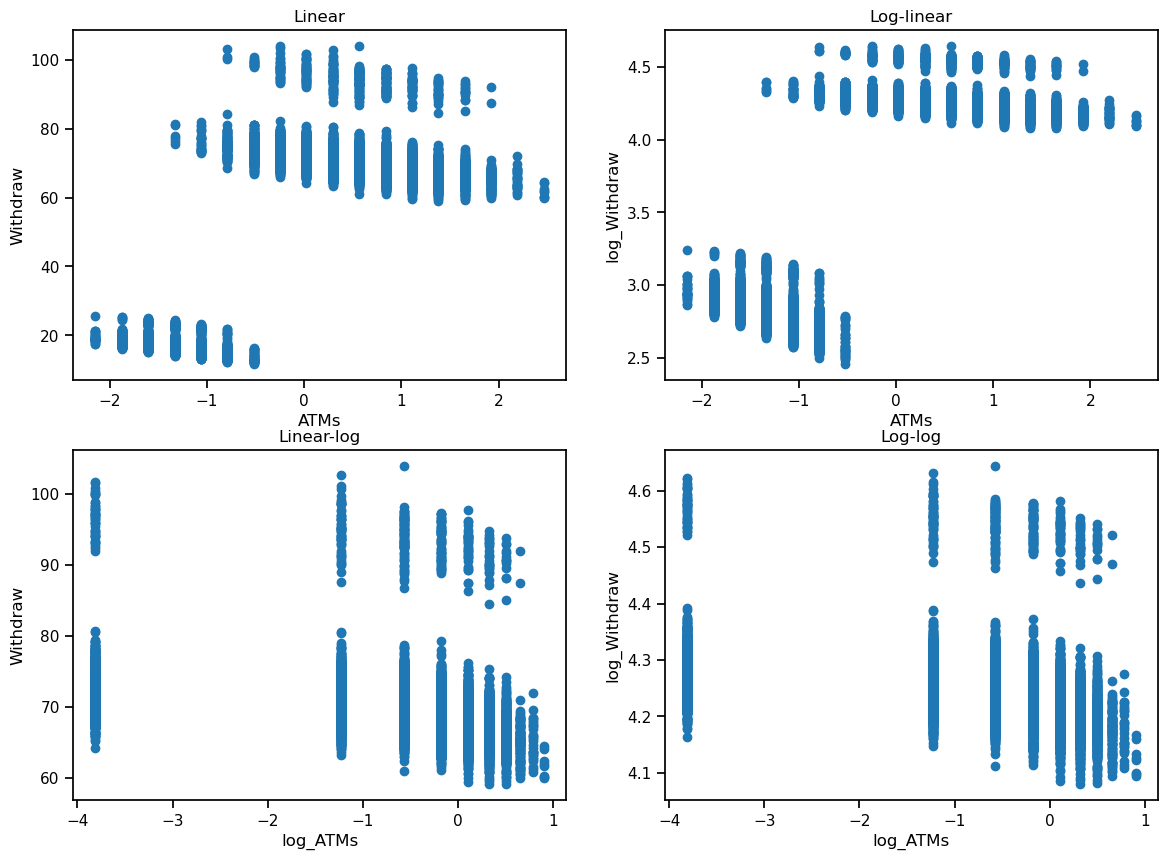

In [148]:
train['log_ATMs'] = np.log(train['ATMs'])
train['log_Withdraw'] = np.log(train['Withdraw'])
val['log_ATMs'] = np.log(val['ATMs'])
val['log_Withdraw'] = np.log(val['Withdraw'])
data_train['log_ATMs'] = np.log(data_train['ATMs'])
data_train['log_Withdraw'] = np.log(data_train['Withdraw'])

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.scatter(train['ATMs'],train['Withdraw'])
ax1.set(title='Linear', ylabel='Withdraw', xlabel='ATMs')
ax2.scatter(train['ATMs'],train['log_Withdraw'])
ax2.set(title='Log-linear', ylabel='log_Withdraw', xlabel='ATMs')
ax3.scatter(train['log_ATMs'],train['Withdraw'])
ax3.set(title='Linear-log', ylabel='Withdraw', xlabel='log_ATMs')
ax4.scatter(train['log_ATMs'],train['log_Withdraw'])
ax4.set(title='Log-log', ylabel='log_Withdraw', xlabel='log_ATMs')
plt.show()

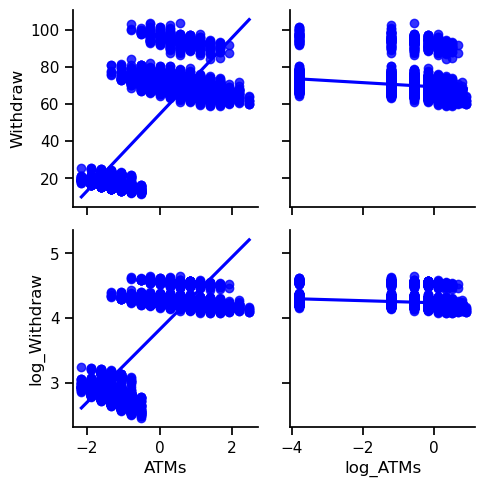

In [149]:
g = sns.PairGrid(train, y_vars=["Withdraw", "log_Withdraw"], x_vars=["ATMs", "log_ATMs"])
g.map(sns.regplot, color="blue")

**Findings:** From the plot we find that the model doesn't perform well by conducting log transformation. ATMs is a discrete variable, which might influence on log model performance. 

In [150]:
formula='Withdraw ~ log_ATMs + Downtown + Weekday + Center + High'
ols = smf.ols(formula=formula, data=train).fit()
resid = ols.resid
fitted = ols.fittedvalues
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     2540.
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:27   Log-Likelihood:                -29950.
No. Observations:               11025   AIC:                         5.991e+04
Df Residuals:                   11020   BIC:                         5.995e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     48.5172      0.029   1660.343      0.000      48.460      48.575
log_ATMs      -1.1186      0.027    -41.097      0.000      -1.172      -1.065
Downtown      31.8170      0.019   1660.343      0.000      31.779      31.855
Weekday       -1.7830      0.035    -50.932      0.000      -1.852      -1.714
Center         2.6247      0.035     74.815      0.000       2.556       2.693
High           0.4345      0.035     12.445      0.000       0.366       0.503
==============================================================================
Omnibus:                     2317.629   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8806.800
Skew:                           1.012   Prob(JB):                         0.00
Kurtosis:                       6.883   Cond. No.                     1.07e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.88e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [151]:
#train set linear-log
predictions = ols.predict(train)
residuals = train['Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 13.398993190010094


In [152]:
#val set linear-log
predictions = ols.predict(val)
residuals = val['Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 15.193972272511953


In [153]:
formula='Withdraw ~ log_ATMs * Downtown + Weekday + Center + High'
ols = smf.ols(formula=formula, data=train).fit()
resid = ols.resid
fitted = ols.fittedvalues
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     2540.
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:27   Log-Likelihood:                -29950.
No. Observations:               11025   AIC:                         5.991e+04
Df Residuals:                   11020   BIC:                         5.995e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            48.5172      0.029   1660.343      0.000      48.460      48.575
log_ATMs             -0.7822      0.019    -41.097      0.000      -0.820      -0.745
Downtown             31.8170      0.019   1660.343      0.000      31.779      31.855
log_ATMs:Downtown    -0.5130      0.012    -41.097      0.000      -0.537      -0.489
Weekday              -1.7830      0.035    -50.932      0.000      -1.852      -1.714
Center                2.6247      0.035     74.815      0.000       2.556       2.693
High                  0.4345      0.035     12.445      0.000       0.366       0.503
==============================================================================
Omnibus:                     2317.629   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8806.800
Skew:                           1.012   Prob(JB):                         0.00
Kurtosis:                       6.883   Cond. No.                     1.32e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.51e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The MSE on the train set of linear-log regression:

In [154]:
predictions = ols.predict(train)
residuals = train['Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 13.398993190010097


The MSE on the validation set of linear-log regression:

In [155]:
predictions = ols.predict(val)
residuals = val['Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 15.213884405742073


In [156]:
formula='log_Withdraw ~ ATMs + Downtown + Weekday + Center + High'
ols = smf.ols(formula=formula, data=train).fit()
resid = ols.resid
fitted = ols.fittedvalues
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_Withdraw   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 5.380e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:27   Log-Likelihood:                 26455.
No. Observations:               17600   AIC:                        -5.290e+04
Df Residuals:                   17594   BIC:                        -5.285e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8221      0.000   9419.687      0.000       3.821       3.823
ATMs          -0.0697      0.001    -83.541      0.000      -0.071      -0.068
Downtown       0.7238      0.001    867.054      0.000       0.722       0.725
Weekday       -0.0344      0.000    -84.645      0.000      -0.035      -0.034
Center         0.0411      0.000    101.324      0.000       0.040       0.042
High           0.0127      0.000     31.268      0.000       0.012       0.013
==============================================================================
Omnibus:                      158.253   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              242.296
Skew:                          -0.076   Prob(JB):                     2.43e-53
Kurtosis:                       3.554   Cond. No.                         3.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The MSE on train set of log-linear regression model:

In [157]:
predictions = ols.predict(train)
residuals = train['log_Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.002896704771269387


The MSE on validation set of log-linear regression model:

In [158]:
predictions = ols.predict(val)
residuals = val['log_Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0035219829816616473


Log-linear with interaction model:

In [159]:
formula='log_Withdraw ~ ATMs * Downtown + Weekday + Center + High'
ols = smf.ols(formula=formula, data=train).fit()
resid = ols.resid
fitted = ols.fittedvalues
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_Withdraw   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 5.707e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:27   Log-Likelihood:                 28567.
No. Observations:               17600   AIC:                        -5.712e+04
Df Residuals:                   17593   BIC:                        -5.706e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.7538      0.001   3566.841      0.000       3.752       3.756
ATMs             -0.1039      0.001   -116.685      0.000      -0.106      -0.102
Downtown          0.8130      0.001    545.909      0.000       0.810       0.816
ATMs:Downtown     0.0782      0.001     69.066      0.000       0.076       0.080
Weekday          -0.0340      0.000    -94.404      0.000      -0.035      -0.033
Center            0.0414      0.000    114.899      0.000       0.041       0.042
High              0.0127      0.000     35.318      0.000       0.012       0.013
==============================================================================
Omnibus:                      247.486   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              405.624
Skew:                           0.121   Prob(JB):                     8.31e-89
Kurtosis:                       3.703   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The MSE on train set of log-linear regression model:(With interaction effect)

In [160]:
predictions = ols.predict(train)
residuals = train['log_Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.002278833228761


The MSE on validation set of linear-log regression model: (With interaction effect)

In [161]:
predictions = ols.predict(val)
residuals = val['log_Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0028392259417782417


In [162]:
formula='log_Withdraw ~ log_ATMs * Downtown + Weekday + Center + High'
ols = smf.ols(formula=formula, data=train).fit()
resid = ols.resid
fitted = ols.fittedvalues
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_Withdraw   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     2553.
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:28   Log-Likelihood:                 17861.
No. Observations:               11025   AIC:                        -3.571e+04
Df Residuals:                   11020   BIC:                        -3.567e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.9630      0.000   7751.323      0.000       2.962       2.964
log_ATMs             -0.0112      0.000    -44.814      0.000      -0.012      -0.011
Downtown              1.9431      0.000   7751.323      0.000       1.943       1.944
log_ATMs:Downtown    -0.0073      0.000    -44.814      0.000      -0.008      -0.007
Weekday              -0.0234      0.000    -51.028      0.000      -0.024      -0.022
Center                0.0334      0.000     72.725      0.000       0.032       0.034
High                  0.0062      0.000     13.595      0.000       0.005       0.007
==============================================================================
Omnibus:                     1266.002   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3178.034
Skew:                           0.664   Prob(JB):                         0.00
Kurtosis:                       5.271   Cond. No.                     1.32e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.51e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### 5.5 Polynomial function

In [163]:
# Retrieved from Kaggle
dimensions = [1, 2, 3, 4, 5,6]
features = ['ATMs', 'Downtown', 'Weekday', 'Center', 'High']
x_train = train[features]
y_train = train['Withdraw']
x_test = test[features]

for dimension in dimensions:
    model = make_pipeline(PolynomialFeatures(dimension), LinearRegression())
    model.fit(x_train, y_train)
    scores = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=6)
    print(f'dimension {dimension}: Average MSE = {np.mean(-scores)}')

dimension 1: Average MSE = 9.693797881082999
dimension 2: Average MSE = 5.045340509085614
dimension 3: Average MSE = 3.7443128090543216
dimension 4: Average MSE = 3.7470164751974373
dimension 5: Average MSE = 3.7516445273081502
dimension 6: Average MSE = 3.759244141468207


In [164]:
for dimension in dimensions:
    model = make_pipeline(PolynomialFeatures(dimension), LinearRegression())
    model.fit(x_train, y_train)
    scores = cross_val_score(model, x_train, y_train, scoring='r2', cv=6)
    print(f'dimension {dimension}: Average R-squared = {np.mean(scores)}')

dimension 1: Average R-squared = 0.9846933383401685
dimension 2: Average R-squared = 0.9920307381169993
dimension 3: Average R-squared = 0.994084006729659
dimension 4: Average R-squared = 0.9940797365118725
dimension 5: Average R-squared = 0.9940724081954698
dimension 6: Average R-squared = 0.9940604680629804


**Findings:** Degree 4 has the smallest MSE and highest R-squared value amongst all the models. Average MSE dropped quickly from degree 1 to 3, and there's only 0.01 decrease from degree 3 to degree 4. 

**Conclusion:** We will try degree 3 and degree 4. Degree 4 has better MSE and R-squared score, whilest degree 3 has adventage in model complexity.

In [165]:
formula='Withdraw ~ Downtown + Weekday + Center + High + np.power(ATMs, 3)'
ols = smf.ols(formula=formula, data=train).fit()
resid = ols.resid
fitted = ols.fittedvalues
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.988e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:39   Log-Likelihood:                -46087.
No. Observations:               17600   AIC:                         9.219e+04
Df Residuals:                   17594   BIC:                         9.223e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            54.2025      0.026   2117.687      0.000      54.152      54.253
Downtown             26.3041      0.037    709.448      0.000      26.231      26.377
Weekday              -1.5603      0.025    -62.343      0.000      -1.609      -1.511
Center                2.2110      0.025     88.349      0.000       2.162       2.260
High                  0.4625      0.025     18.482      0.000       0.413       0.512
np.power(ATMs, 3)    -0.9791      0.018    -55.703      0.000      -1.014      -0.945
==============================================================================
Omnibus:                     6850.767   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52891.288
Skew:                           1.674   Prob(JB):                         0.00
Kurtosis:                      10.805   Cond. No.                         3.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [166]:
feature1 = x_train
feature1 = sm.add_constant(feature1)  

for i in range(5):
    vif.append(variance_inflation_factor(feature1.values, i+1))

sum(vif)/5

1655.1982307483154

## 5.6 Summary Table: model performance on train and Validation set (All models in modelling section)

Test seperately on train set anf validation set.

Model performance: 
| Model | Train MSE | Validation MSE | 
| --- | --- | --- |
| Benchmark Model (OLS Reg) | 6.1869 | 6.6361|
| Benchmark Ridge Regression | 6.1870| 6.6355 |
| MLR (stepwise) | 6.3895| 6.7900|
| MLR Reg (Drop Shops) |  9.6501| 9.9952|
| MLR Reg (Drop Shops interaction) | 5.0516| 5.2605|
| MLR Reg (Drop Shops interaction Ridge) | 5.0516| 5.2505|
|linear-log|13.6995|1.6195e+19|
|log-linear|0.0029|0.0031|
|log-linear(interaction)|0.0023|0.0024|


- The log-linear, log-linear with interaction, MLR Reg (Drop Shops interaction Ridge) performs relatively well. We will test its performance on the whole training set in the next part.
- Polynomial do tested via MSE. Yet the VIF and MSE doesn't perform well.

## 6.0 Model evaluation

On this step we will test model performance on the **whole train set**

Benchmark Model

In [167]:
x_with_intercept = sm.add_constant(data_train[predictors_train], prepend=True)
ols = sm.OLS(data_train[response],x_with_intercept)
est = ols.fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               Withdraw   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.656e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:39   Log-Likelihood:                -51380.
No. Observations:               22000   AIC:                         1.028e+05
Df Residuals:                   21993   BIC:                         1.028e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4284      0.111     94.198      0.0

In [168]:
np.mean((est.predict(sm.add_constant(data_train[predictors_train], prepend=True)).to_numpy() - data_train[response].to_numpy().T)**2)

6.252746531168425

Benchmark Model With Ridge

In [169]:
ridge = RidgeCV(cv=10)
ridge.fit(data_train[predictors_train], np.ravel(data_train[response])) 

RidgeCV(cv=10)

In [170]:
print("Ridge Lambda: {0}".format(ridge.alpha_))

Ridge Lambda: 0.1


In [171]:
# Print alpha for regularisation
ridge_reg = linear_model.Ridge(alpha=ridge.alpha_)
ridge_reg.fit(data_train[predictors_train], np.ravel(data_train[response]))

Ridge(alpha=0.1)

In [172]:
np.mean((ridge_reg.predict(data_train[predictors_train]) - data_train[response].to_numpy().T)**2)

6.252824518188559

MLR Reg (Drop Shops, Downtown as interaction, Ridge):

In [173]:
features = ['ATMs', 'Downtown', 'Weekday', 'Center', 'High']
x_train = data_train[features]
y_train = data_train['Withdraw']

data_train1 = data_train.copy()
data_train1['ATMs_Downtown'] = data_train1['ATMs'] * data_train1['Downtown']

features_interaction = ['ATMs', 'Downtown', 'Weekday', 'Center', 'High', 'ATMs_Downtown']
x_train = data_train1[features_interaction]

In [174]:
x_train_interactions = poly.fit_transform(x_train[features_interaction])

In [175]:
ridge = RidgeCV(cv=10)
ridge.fit(x_train_interactions, y_train) 

RidgeCV(cv=10)

In [176]:
print("Ridge Lambda: {0}".format(ridge.alpha_))

Ridge Lambda: 0.1


In [177]:
ridge_reg = linear_model.Ridge(alpha=ridge.alpha_)
ridge_reg.fit(x_train_interactions, y_train) 

Ridge(alpha=0.1)

In [178]:
#MSE
np.mean((ridge_reg.predict(x_train_interactions) - data_train[response].to_numpy().T)**2)

5.0800410899790736

MLR Reg (Drop Shops interaction)

In [179]:
x_with_intercept = smf.ols(formula= 'Withdraw ~ ATMs * Downtown + Weekday + Center + High', data = data_train) 
est = x_with_intercept.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.345e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:40   Log-Likelihood:                -56206.
No. Observations:               22000   AIC:                         1.124e+05
Df Residuals:                   21993   BIC:                         1.125e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        21.1453      0.124    170.957      0.000      20.903      21.388
ATMs             -0.9848      0.037    -26.449      0.000      -1.058      -0.912
Downtown         61.2397      0.174    352.912      0.000      60.900      61.580
ATMs:Downtown    -0.0312      0.039     -0.795      0.427      -0.108       0.046
Weekday          -3.4659      0.046    -74.568      0.000      -3.557      -3.375
Center            7.2085      0.069    104.094      0.000       7.073       7.344
High              0.9605      0.046     20.992      0.000       0.871       1.050
==============================================================================
Omnibus:                    10312.479   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           104228.263
Skew:                           2.006   Prob(JB):                         0.00
Kurtosis:                      12.880   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [180]:
def calculate_vif(data):
    x = data.values
    vif = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
    return vif

predictors = data_train[['ATMs', 'Downtown', 'Weekday', 'Center', 'High']]
predictors['ATMs_Downtown'] = predictors['ATMs'] * predictors['Downtown']
vif_values = calculate_vif(predictors)

average_vif = sum(vif_values) / len(vif_values)
print("Average VIF:", average_vif)

Average VIF: 24.300708702235635


In [181]:
# MSE
predictions = est.predict(data_train)
residuals = train['Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 9.682442554221868


Log-linear model:

In [182]:
formula='log_Withdraw ~ ATMs + Downtown + Weekday + Center + High'
ols = smf.ols(formula=formula, data=data_train).fit()
resid = ols.resid
fitted = ols.fittedvalues
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_Withdraw   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 6.636e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:40   Log-Likelihood:                 32983.
No. Observations:               22000   AIC:                        -6.595e+04
Df Residuals:                   21994   BIC:                        -6.591e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9012      0.001   2620.409      0.000       2.899       2.903
ATMs          -0.0190      0.000    -93.104      0.000      -0.019      -0.019
Downtown       1.5781      0.002    963.559      0.000       1.575       1.581
Weekday       -0.0761      0.001    -94.333      0.000      -0.078      -0.074
Center         0.1361      0.001    113.246      0.000       0.134       0.138
High           0.0274      0.001     34.565      0.000       0.026       0.029
==============================================================================
Omnibus:                      211.708   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.559
Skew:                          -0.055   Prob(JB):                     4.11e-75
Kurtosis:                       3.601   Cond. No.                         41.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [183]:
# MSE log-linear
predictions = ols.predict(data_train)
residuals = data_train['log_Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.002919575943485233


Log-linear with interaction model:

In [184]:
formula='log_Withdraw ~ ATMs * Downtown + Weekday + Center + High'
ols = smf.ols(formula=formula, data=data_train).fit()
resid = ols.resid
fitted = ols.fittedvalues
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_Withdraw   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 7.019e+05
Date:                Sun, 05 May 2024   Prob (F-statistic):               0.00
Time:                        23:53:40   Log-Likelihood:                 35591.
No. Observations:               22000   AIC:                        -7.117e+04
Df Residuals:                   21993   BIC:                        -7.111e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.0264      0.002   1587.598      0.000       3.023       3.030
ATMs             -0.0608      0.001   -105.878      0.000      -0.062      -0.060
Downtown          1.4060      0.003    525.701      0.000       1.401       1.411
ATMs:Downtown     0.0464      0.001     76.714      0.000       0.045       0.048
Weekday          -0.0754      0.001   -105.188      0.000      -0.077      -0.074
Center            0.1364      0.001    127.789      0.000       0.134       0.138
High              0.0273      0.001     38.761      0.000       0.026       0.029
==============================================================================
Omnibus:                      343.251   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              543.059
Skew:                           0.155   Prob(JB):                    1.19e-118
Kurtosis:                       3.705   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [185]:
predictions = ols.predict(data_train)
residuals = data_train['log_Withdraw'] - predictions
mse = np.mean(residuals**2)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0023032587155024722


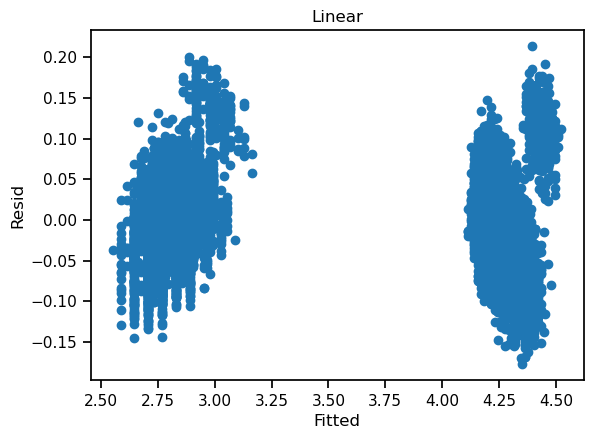

In [186]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(fitted,resid)
ax1.set(title='Linear', ylabel='Resid', xlabel='Fitted')
plt.show()

## 7.0 Summary Table

| Model | Whole train set MSE |Train MSE | Validation MSE | 
| --- | --- |  --- | --- |
| Benchmark Model (OLS Reg) | 6.2527 | 6.1869 | 6.6361|
| Ridge Regression (Benchmark) | 6.2528 |6.1870| 6.6355 |
| MLR Reg (Drop Shops, interaction) | 9.6506| 5.0516| 5.2605|
| MLR (Ridge, interaction) | 5.0801| 5.0516| 5.2505|
|Log-Linear| 0.0029|0.0029|0.0031|
|log-linear with interaction|0.0023|0.0023|0.0024|

Best performance model is log-linear model with interaction effect.

## 8.0 Test set performance

In [ ]:
data_test = pd.read_csv('ATM_test.csv', index_col=[0])
print(data_test.shape)
data_test.head()

In [ ]:
data_test.index = pd.to_datetime(data_test.index)

In [ ]:
mse = mean_squared_error(data_test['CPI'], forecast)
print(f'MSE: {mse}')

In [193]:
#x_test = data_test[['ATMs', 'Downtown', 'Weekday', 'Center', 'High']]

#predicted_log_withdraw = model.predict(x_test)

#predicted_withdraw = np.exp(predicted_log_withdraw)

In [195]:
#data_test['Predicted_Withdraw'] = predicted_withdraw

#data_test.to_csv('ATM_test.csv', index=False)


In [196]:
#predictions = ols.predict(data_train)
#residuals = data_train['log_Withdraw'] - predictions
#mse = np.mean(residuals**2)
#print("Mean Squared Error:", mse)

Mean Squared Error: 0.0023032587155024722


In [ ]:
#ATM_test = pd.read_csv('ATM_test.csv')

## Reference & relative study material:

Buildin, B. (2024). A step-by-step explanation of principal component analysis (PCA). Retrieved from https://builtin.com/data-science/step-step-explanation-principal-component-analysis 

